# VAEP 

In [ ]:
pip install socceraction

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3070, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2863, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/resolut

In [ ]:
import pandas as pd

features = pd.read_csv(path+"/features.csv")
labels = pd.read_csv(path+"/labels.csv")
actions = pd.read_csv(path+"/actions.csv")

NameError: name 'path' is not defined

In [ ]:
# combine
df = pd.concat([features, labels[['scores', 'concedes']]], axis=1)

# 
categorical_cols = df.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    df[col] = df[col].astype("category")  # convert string to dataframe

In [ ]:
# define the target and train
X = df.drop(columns=["scores", "concedes"])
y_scores = df["scores"]
y_concedes = df["concedes"]

In [ ]:
from xgboost import XGBClassifier

score_model = XGBClassifier(eval_metric="logloss", use_label_encoder=False, enable_categorical=True)
score_model.fit(X, y_scores)
df["p_score"] = score_model.predict_proba(X)[:, 1]

concede_model = XGBClassifier(eval_metric="logloss", use_label_encoder=False, enable_categorical=True)
concede_model.fit(X, y_concedes)
df["p_concede"] = concede_model.predict_proba(X)[:, 1]

In [ ]:
from socceraction.vaep.formula import value

df["p_score_next"] = df["p_score"].shift(-1)
df["p_concede_next"] = df["p_concede"].shift(-1)
df["delta_p_score"] = df["p_score_next"] - df["p_score"]
df["delta_p_concede"] = df["p_concede_next"] - df["p_concede"]

df_vaep = value(actions, df["p_score"], df["p_concede"])
print(df_vaep.head())

In [ ]:
# Combine VAEP values with actions
actions_with_vaep = pd.concat([actions, df_vaep], axis=1)

In [ ]:
actions_with_vaep.head()

In [ ]:
actions_with_vaep.columns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
file_path = '/content/drive/MyDrive/SPADL_Data/dataset/actions_with_vaep.csv'


actions_with_vaep.to_csv(file_path, index=False)

# 0 Code
### reference : https://soccermatics.readthedocs.io/en/latest/index.html
### dataset : https://www.hudl.com/en_gb/products/wyscout

In [ ]:
!pip install socceraction
!pip install mplsoccer
!pip install tqdm
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 11.1 MB/s eta 0:00:00
  Attempting uninstall: lxml
    Found existing installation: lxml 5.3.0
    Uninstalling lxml-5.3.0:
      Successfully uninstalled lxml-5.3.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 4.0 MB/s eta 0:00:00


# 1 Dataload


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import warnings
from tqdm import tqdm

from mplsoccer.pitch import Pitch, VerticalPitch
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb

from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, roc_curve

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
warnings.filterwarnings('ignore', category=pd.io.pytables.PerformanceWarning)

In [ ]:
actions= pd.read_csv('/content/drive/MyDrive/SPADL_Data/dataset/actions_with_vaep.csv')

In [ ]:
actions.columns

Index(['Unnamed: 0', 'game_id', 'period_id', 'time_seconds', 'team_id',
       'player_id', 'start_x', 'start_y', 'end_x', 'end_y',
       'original_event_id', 'bodypart_id', 'type_id', 'result_id', 'action_id',
       'type_name', 'result_name', 'bodypart_name', 'offensive_value',
       'defensive_value', 'vaep_value'],
      dtype='object')

In [ ]:
df = actions

In [ ]:
actions['type_name'].unique()

array(['pass', 'cross', 'clearance', 'throw_in', 'dribble', 'foul',
       'freekick_crossed', 'freekick_short', 'interception', 'goalkick',
       'take_on', 'corner_crossed', 'shot', 'keeper_save', 'tackle',
       'corner_short', 'shot_freekick', 'shot_penalty', 'bad_touch'],
      dtype=object)

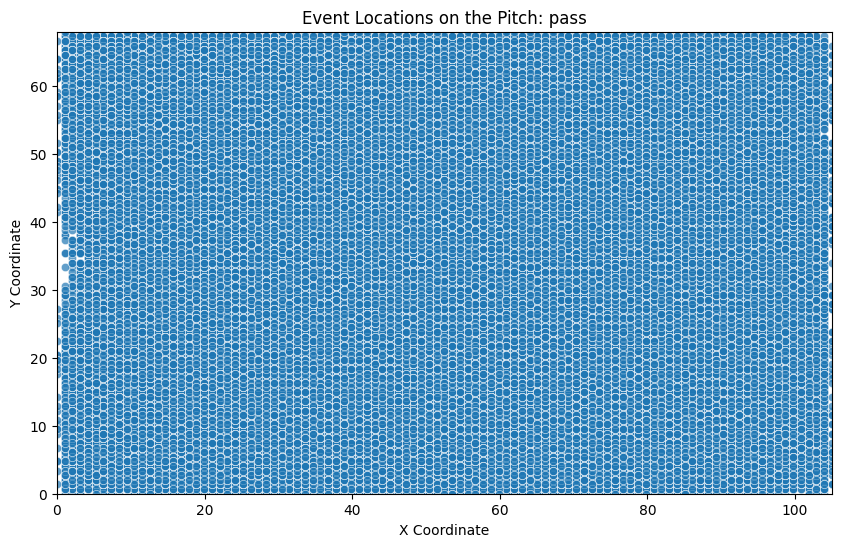

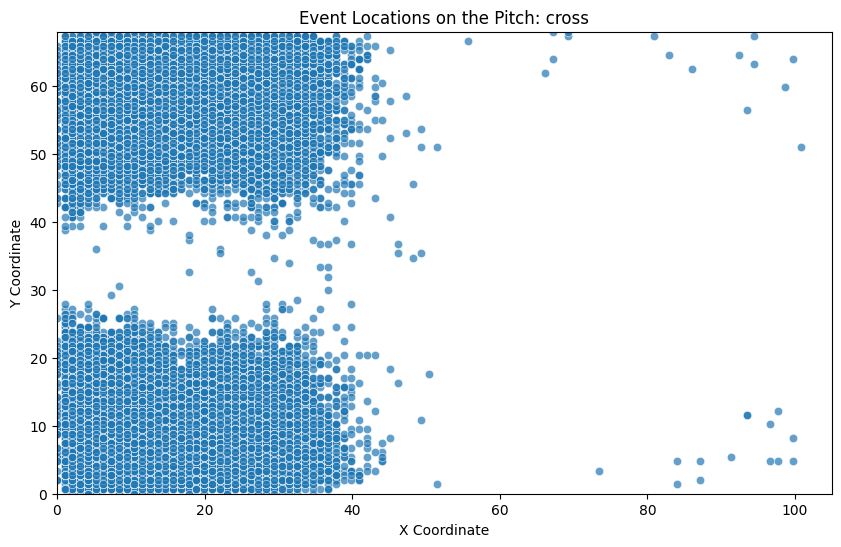

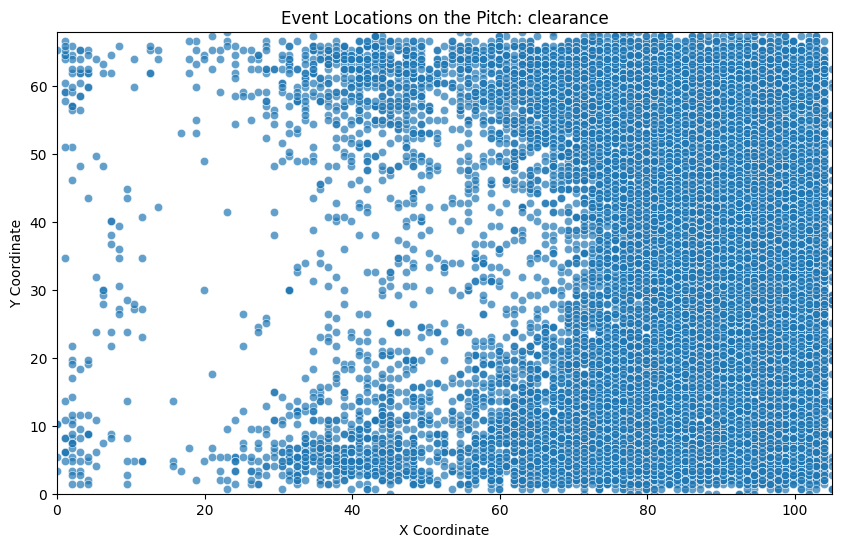

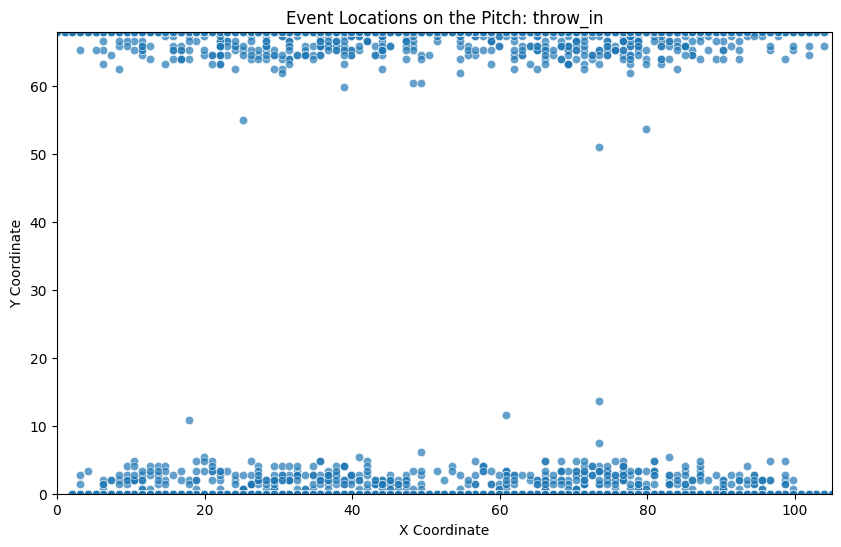

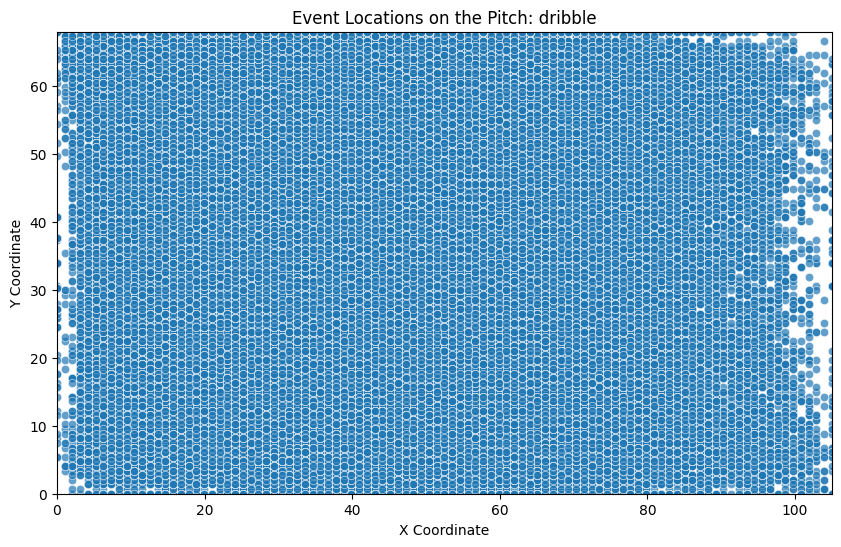

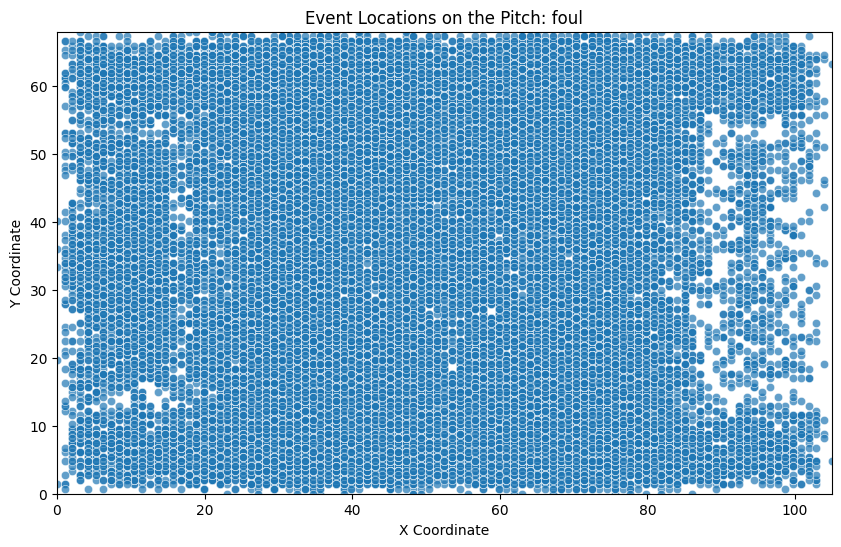

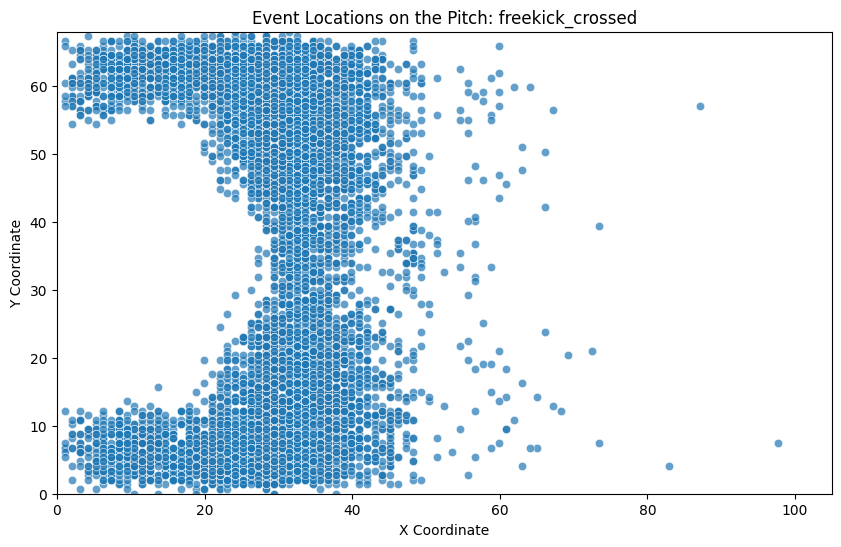

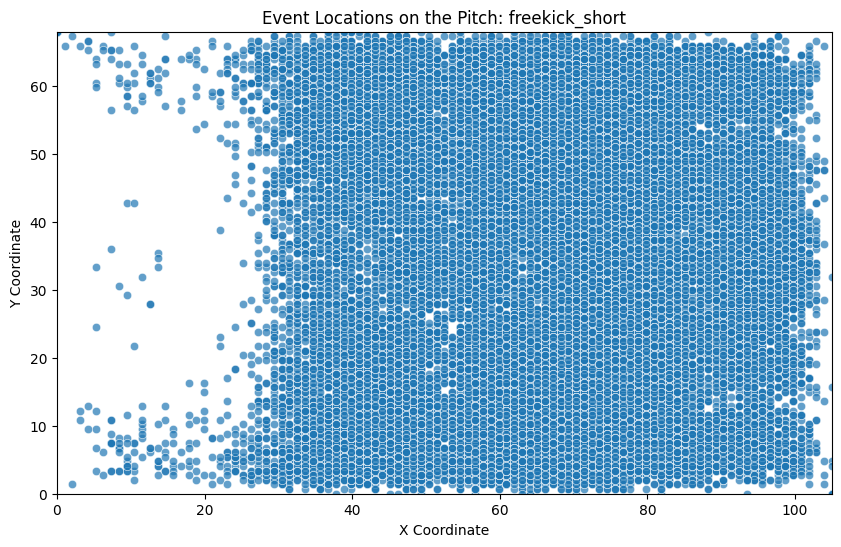

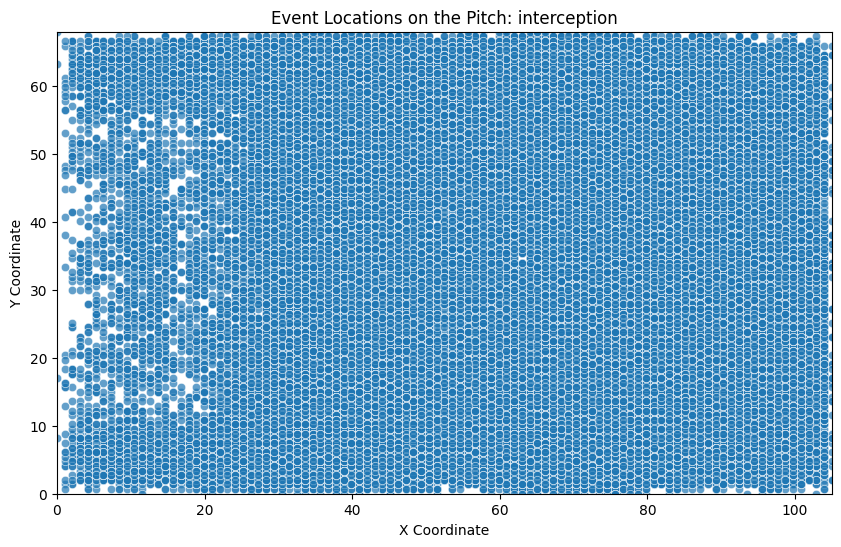

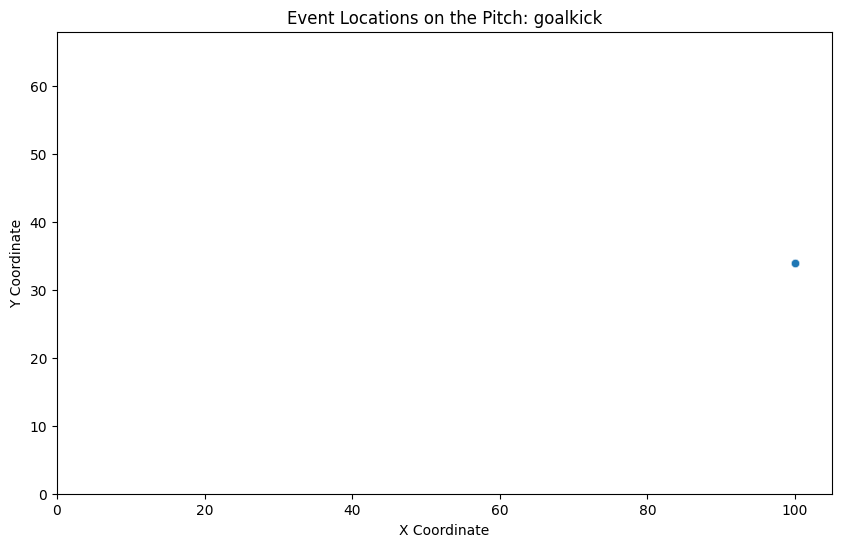

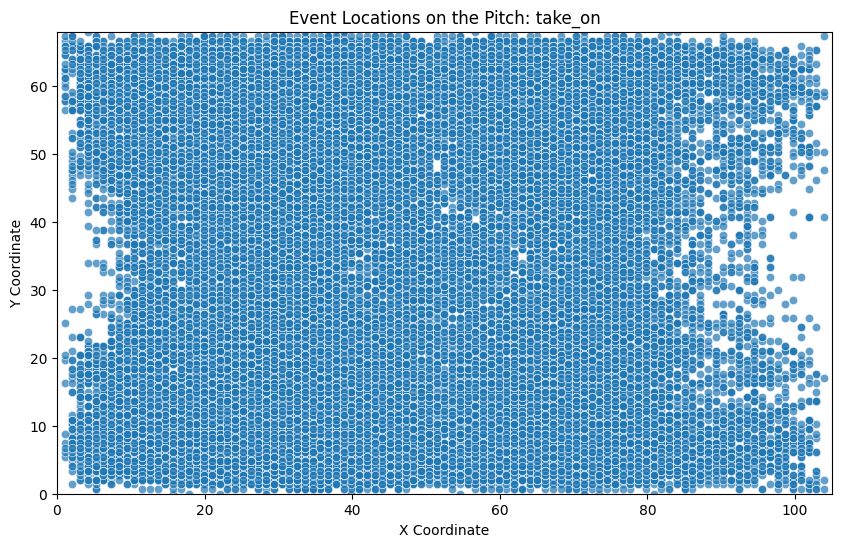

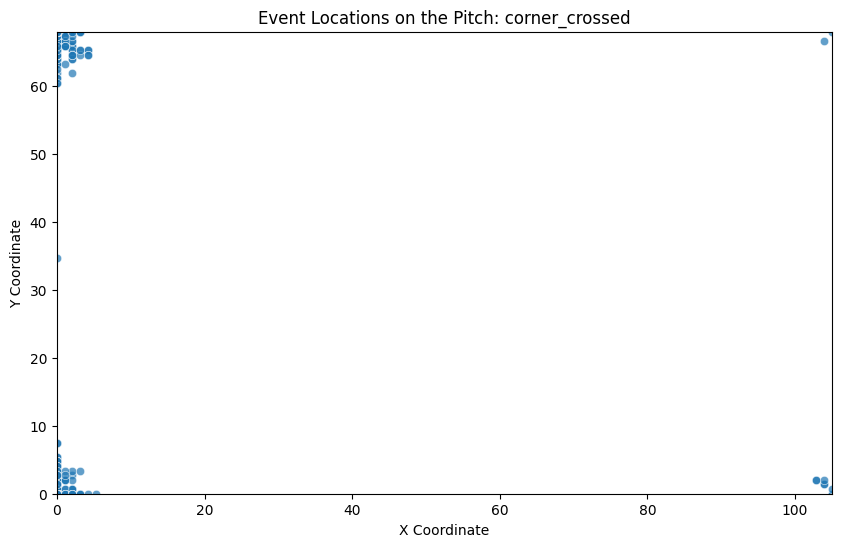

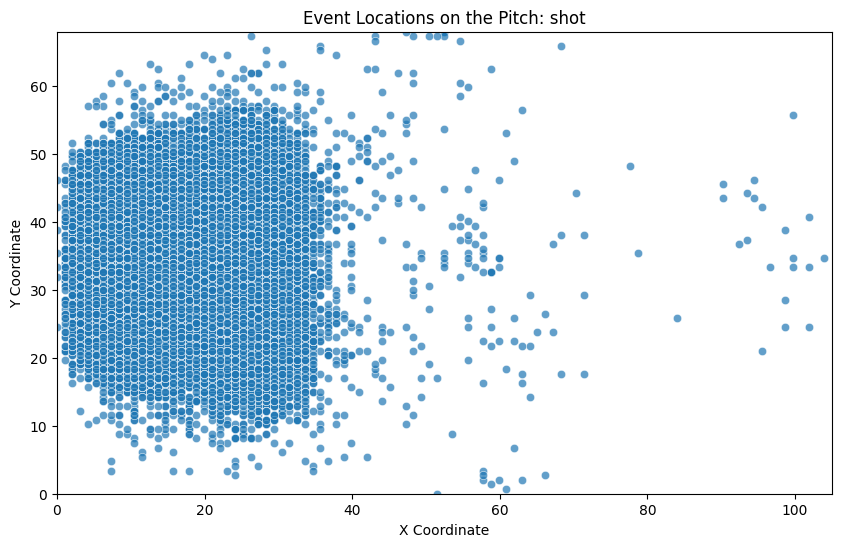

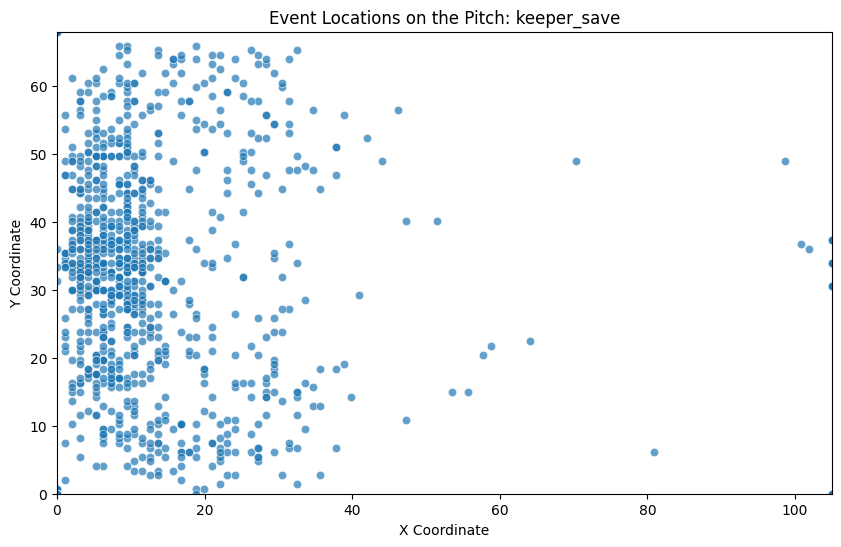

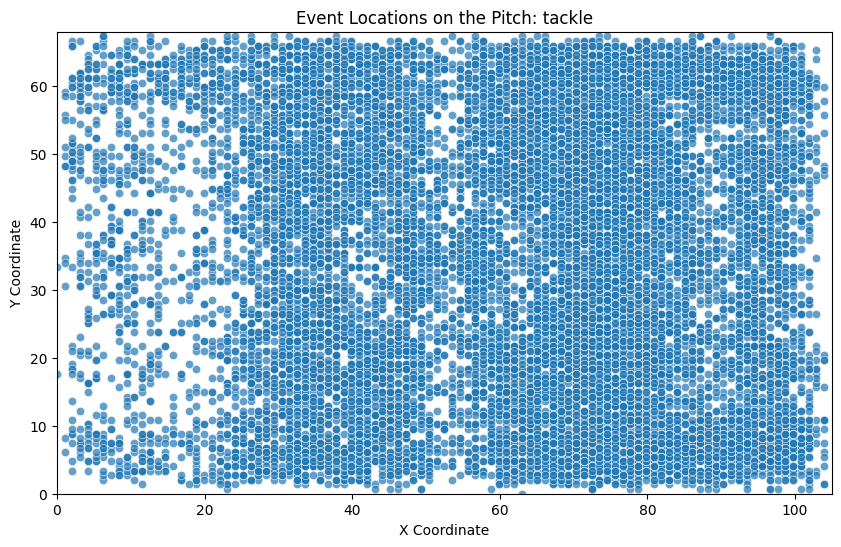

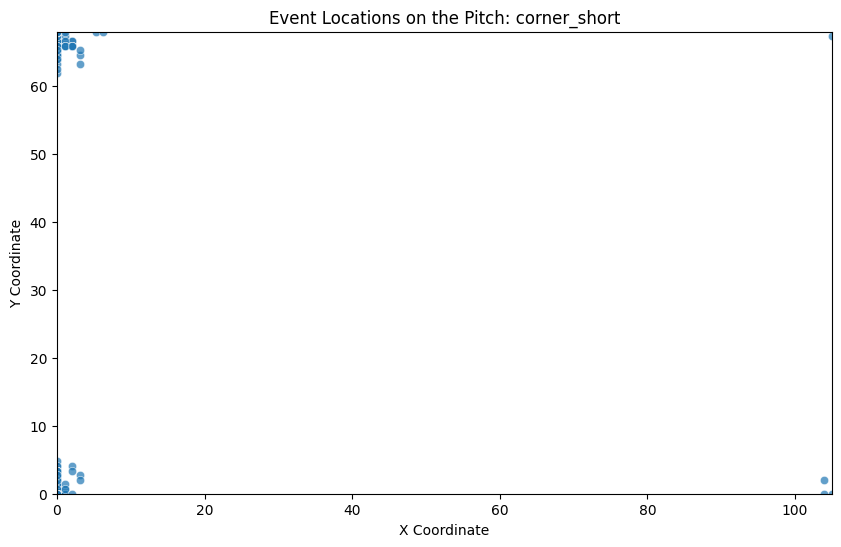

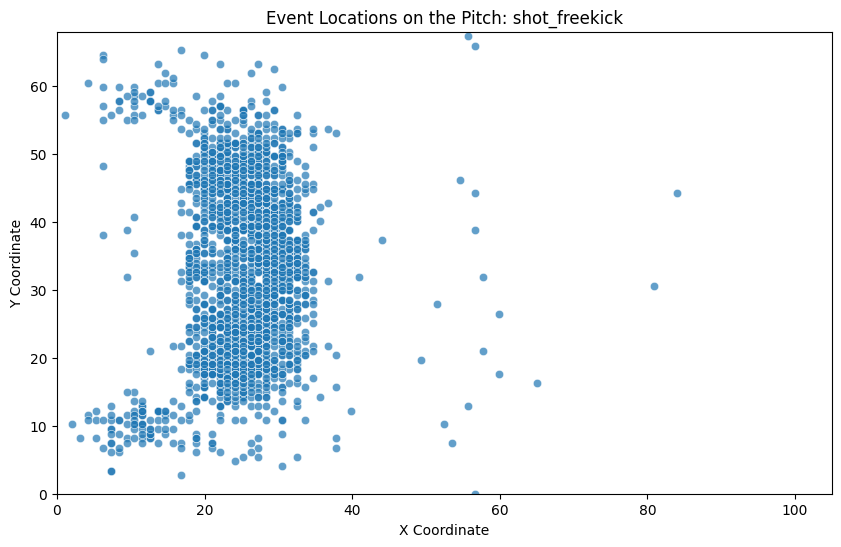

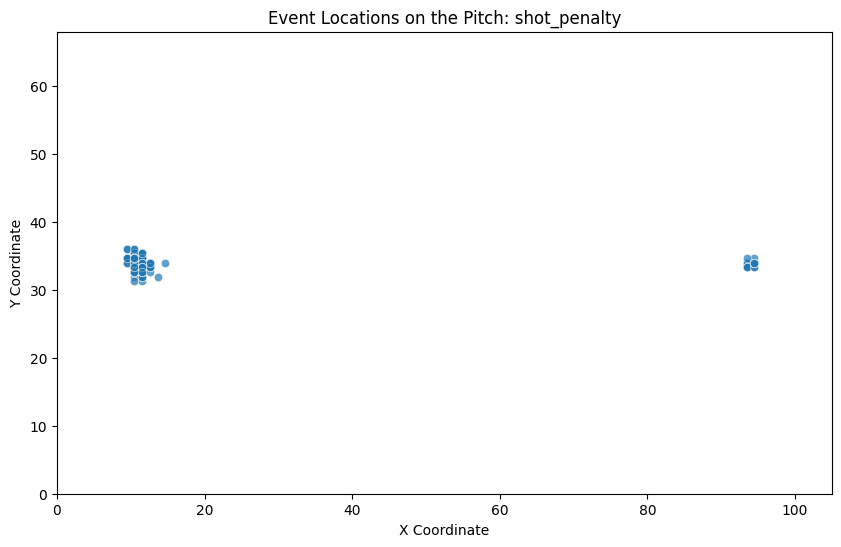

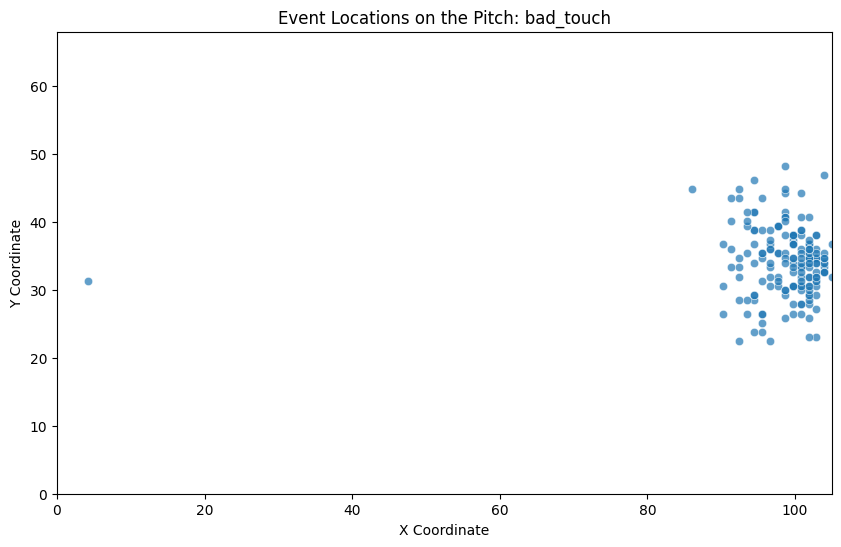

In [ ]:
# Assuming 'df' is your DataFrame
unique_types = df['type_name'].unique()  # type_name의 고유 값 추출

for event_type in unique_types:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=df[df['type_name'] == event_type],
        x='start_x',
        y='start_y',
        alpha=0.7
    )
    plt.title(f'Event Locations on the Pitch: {event_type}')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.xlim(0, 105)  # Assuming pitch length is normalized to 105
    plt.ylim(0, 68)  # Assuming pitch width is normalized to 68
    plt.show()


In [ ]:
actions.describe()

Unnamed: 0       game_id     period_id  time_seconds       team_id  \
count  2.462726e+06  2.462726e+06  2.462726e+06  2.462726e+06  2.462726e+06   
mean   1.231362e+06  2.495803e+06  1.496830e+00  1.382021e+03  2.990274e+03   
std    7.109279e+05  1.579431e+05  5.064189e-01  8.320449e+02  2.898998e+03   
min    0.000000e+00  1.694390e+06  1.000000e+00  0.000000e+00  6.740000e+02   
25%    6.156812e+05  2.500090e+06  1.000000e+00  6.548361e+02  1.613000e+03   
50%    1.231362e+06  2.516840e+06  1.000000e+00  1.364079e+03  2.460000e+03   
75%    1.847044e+06  2.565832e+06  2.000000e+00  2.096673e+03  3.766000e+03   
max    2.462725e+06  2.576338e+06  5.000000e+00  3.534783e+03  1.983000e+04   

          player_id       start_x       start_y         end_x         end_y  \
count  2.462726e+06  2.462726e+06  2.462726e+06  2.462726e+06  2.462726e+06   
mean   8.725412e+04  5.484526e+01  3.390635e+01  4.753029e+01  3.382522e+01   
std    1.155894e+05  2.542643e+01  2.014023e+01  2.543674e+01  2.017090e+01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    8.958000e+03  3.465000e+01  1.632000e+01  2.835000e+01  1.632000e+01   
50%    2.553700e+04  5.670000e+01  3.400000e+01  4.515000e+01  3.400000e+01   
75%    1.343990e+05  7.350000e+01  5.168000e+01  6.825000e+01  5.168000e+01   
max    5.685830e+05  1.050000e+02  6.800000e+01  1.050000e+02  6.800000e+01   

       original_event_id   bodypart_id       type_id     result_id  \
count       2.294126e+06  2.462726e+06  2.462726e+06  2.462726e+06   
mean        2.157923e+08  1.425847e-01  3.774789e+00  8.160230e-01   
std         3.017326e+07  4.812491e-01  6.830892e+00  3.950910e-01   
min         8.817864e+07  0.000000e+00  0.000000e+00  0.000000e+00   
25%         1.988792e+08  0.000000e+00  0.000000e+00  1.000000e+00   
50%         2.190778e+08  0.000000e+00  0.000000e+00  1.000000e+00   
75%         2.352287e+08  0.000000e+00  4.000000e+00  1.000000e+00   
max         2.802175e+08  3.000000e+00  2.200000e+01  3.000000e+00   

          action_id  offensive_value  defensive_value    vaep_value  
count  2.462726e+06     2.462726e+06     2.462726e+06  2.462726e+06  
mean   6.387260e+02     3.085444e-03    -1.621389e-05  3.069230e-03  
std    3.746623e+02     4.152320e-02     1.597529e-02  4.452418e-02  
min    0.000000e+00    -8.069467e-01    -9.969468e-01 -1.632343e+00  
25%    3.170000e+02    -2.003222e-03    -1.302297e-03 -3.268485e-03  
50%    6.340000e+02     7.174276e-04    -7.714507e-05  9.056691e-04  
75%    9.510000e+02     4.338982e-03     9.818080e-04  5.855292e-03  
max    1.803000e+03     9.996525e-01     7.561167e-01  1.016840e+00

In [ ]:
actions

Unnamed: 0  game_id  period_id  time_seconds  team_id  player_id  \
0                 0  2500089          1      2.763597     1659       9637   
1                 1  2500089          1      4.761353     1659       8351   
2                 2  2500089          1      5.533097     1659       9285   
3                 3  2500089          1      7.707561     1659     239411   
4                 4  2500089          1     11.614943     1659       9637   
...             ...      ...        ...           ...      ...        ...   
2462721     2462721  2057954          2   2868.496551    14358     103682   
2462722     2462722  2057954          2   2870.980334    16521     122577   
2462723     2462723  2057954          2   2872.843120    16521     122577   
2462724     2462724  2057954          2   2939.438099    14358     257800   
2462725     2462725  2057954          2   2983.382036    16521     122623   

         start_x  start_y  end_x  end_y  ...  bodypart_id  type_id  result_id  \
0          52.50    34.00  63.00  30.60  ...            0        0          1   
1          63.00    30.60  64.05  10.20  ...            0        0          1   
2          64.05    10.20  72.45  20.40  ...            0        0          1   
3          72.45    20.40  35.70  19.04  ...            0        0          1   
4          35.70    19.04  30.45  12.24  ...            0        0          1   
...          ...      ...    ...    ...  ...          ...      ...        ...   
2462721    28.35    48.96  23.10  47.60  ...            0        0          1   
2462722    81.90    20.40  80.85  25.16  ...            0        9          0   
2462723    80.85    25.16  80.85  25.16  ...            0        8          1   
2462724    19.95    45.56   0.00  37.40  ...            0       13          1   
2462725    52.50    34.00   0.00  68.00  ...            0        0          0   

         action_id      type_name result_name bodypart_name offensive_value  \
0                0           pass     success          foot        0.000000   
1                1           pass     success          foot       -0.000566   
2                2           pass     success          foot        0.000365   
3                3           pass     success          foot        0.002239   
4                4           pass     success          foot        0.000198   
...            ...            ...         ...           ...             ...   
2462721       1215           pass     success          foot        0.164894   
2462722       1216         tackle        fail          foot        0.044484   
2462723       1217           foul     success          foot       -0.002979   
2462724       1218  shot_freekick     success          foot        0.999653   
2462725       1219           pass        fail          foot        0.004000   

         defensive_value  vaep_value  
0              -0.000000    0.000000  
1               0.000043   -0.000523  
2              -0.000567   -0.000202  
3               0.000222    0.002462  
4              -0.000139    0.000059  
...                  ...         ...  
2462721         0.000407    0.165301  
2462722        -0.199207   -0.154723  
2462723        -0.129319   -0.132298  
2462724        -0.001436    0.998217  
2462725        -0.002258    0.001742  

[2462726 rows x 21 columns]

In [ ]:
offensive_actions = ['cross', 'clearance', 'freekick_crossed', 'shot', 'tackle', 'keeper_save']
offensive_data = actions[actions["type_name"].isin(offensive_actions)]

offensive_data = offensive_data[offensive_data['vaep_value'] >=0]
offensive_data = offensive_data[offensive_data["start_x"] <= 35]
offensive_data = offensive_data[
    ~((offensive_data["type_name"].isin(["cross", "pass"])) & (offensive_data["result_name"] == "offside"))
]

In [ ]:
offensive_data

Unnamed: 0  game_id  period_id  time_seconds  team_id  player_id  \
8                 8  2500089          1     21.436162     1659       9285   
135             135  2500089          1    598.000494     1646         93   
401             401  2500089          1   1651.208686     1659       9637   
407             407  2500089          1   1709.765578     1646         93   
481             481  2500089          1   2039.936246     1646       8125   
...             ...      ...        ...           ...      ...        ...   
2462517     2462517  2057954          2   1886.485618    14358     257800   
2462640     2462640  2057954          2   2445.791943    14358     101857   
2462649     2462649  2057954          2   2526.179179    16521     122615   
2462683     2462683  2057954          2   2632.363652    14358     103682   
2462696     2462696  2057954          2   2748.725583    14358       4513   

         start_x  start_y  end_x  end_y  ...  bodypart_id  type_id  result_id  \
8           2.10     8.16   2.10   8.16  ...            0        1          0   
135        25.20     2.04  11.55  25.84  ...            0        1          0   
401        11.55    56.44   0.00  34.00  ...            0       11          0   
407        10.50     4.76   4.20  44.20  ...            0        1          1   
481        25.20    51.68  12.60  26.52  ...            0        1          1   
...          ...      ...    ...    ...  ...          ...      ...        ...   
2462517    23.10    58.48  12.60  38.08  ...            0        3          1   
2462640    26.25     1.36  11.55  27.88  ...            0        3          0   
2462649     8.40    51.00  10.50  39.44  ...            0        1          0   
2462683     9.45    59.84   0.00  50.32  ...            0        1          0   
2462696    14.70    19.72   0.00  37.40  ...            0       11          1   

         action_id         type_name result_name bodypart_name  \
8                8             cross        fail          foot   
135            135             cross        fail          foot   
401            401              shot        fail          foot   
407            407             cross     success          foot   
481            481             cross     success          foot   
...            ...               ...         ...           ...   
2462517       1011  freekick_crossed     success          foot   
2462640       1134  freekick_crossed        fail          foot   
2462649       1143             cross        fail          foot   
2462683       1177             cross        fail          foot   
2462696       1190              shot     success          foot   

        offensive_value  defensive_value  vaep_value  
8              0.000076         0.001990    0.002066  
135            0.000232         0.000123    0.000355  
401            0.003160        -0.001722    0.001438  
407            0.020833         0.001161    0.021994  
481            0.024079         0.001125    0.025204  
...                 ...              ...         ...  
2462517        0.083544        -0.001469    0.082076  
2462640        0.022713        -0.002156    0.020557  
2462649        0.001001         0.006960    0.007961  
2462683        0.185116        -0.001907    0.183209  
2462696        0.553035         0.000502    0.553538  

[39150 rows x 21 columns]

In [ ]:
offensive_data.describe()

Unnamed: 0       game_id      period_id   time_seconds  \
count  2.319500e+05  2.319500e+05  231950.000000  231950.000000   
mean   1.224769e+06  2.492096e+06       1.534262    1442.578495   
std    7.265558e+05  1.645525e+05       0.506034     824.456009   
min    5.000000e+00  1.694390e+06       1.000000       0.500000   
25%    5.764862e+05  2.500054e+06       1.000000     730.977213   
50%    1.228894e+06  2.516823e+06       2.000000    1445.863940   
75%    1.864406e+06  2.565825e+06       2.000000    2152.658050   
max    2.462721e+06  2.576338e+06       4.000000    3489.784429   

             team_id      player_id        start_x        start_y  \
count  231950.000000  231950.000000  231950.000000  231950.000000   
mean     2973.674223   90587.175598      24.095569      34.465893   
std      2951.521944  117707.853142       9.145547      21.695770   
min       674.000000       0.000000       0.000000       0.000000   
25%      1612.000000    9194.000000      17.850000      13.600000   
50%      2455.000000   25707.000000      27.300000      34.680000   
75%      3315.000000  135913.000000      31.500000      55.760000   
max     19830.000000  568583.000000      34.650000      68.000000   

               end_x          end_y  original_event_id    bodypart_id  \
count  231950.000000  231950.000000       1.942810e+05  231950.000000   
mean       20.132486      34.299832       2.160070e+08       0.038366   
std        13.421693      18.717149       3.096909e+07       0.260678   
min         0.000000       0.000000       8.817865e+07       0.000000   
25%        10.500000      19.040000       1.996732e+08       0.000000   
50%        18.900000      34.000000       2.191856e+08       0.000000   
75%        28.350000      49.640000       2.388393e+08       0.000000   
max       105.000000      68.000000       2.802175e+08       3.000000   

             type_id      result_id      action_id  offensive_value  \
count  231950.000000  231950.000000  231950.000000    231950.000000   
mean        4.240013       0.916172     675.814201         0.036531   
std         7.967079       0.277131     370.121627         0.114357   
min         0.000000       0.000000       0.000000        -0.150212   
25%         0.000000       1.000000     364.000000         0.003282   
50%         0.000000       1.000000     685.000000         0.009122   
75%         1.000000       1.000000     985.000000         0.024894   
max        21.000000       1.000000    1784.000000         0.998541   

       defensive_value    vaep_value  
count    231950.000000  2.319500e+05  
mean          0.000342  3.687257e-02  
std           0.005001  1.142336e-01  
min          -0.159331  5.587935e-09  
25%          -0.000660  3.551516e-03  
50%           0.000036  9.433056e-03  
75%           0.000858  2.517095e-02  
max           0.681216  1.016840e+00

In [ ]:
offensive_data["type_name"].value_counts()

type_name
cross               22504
shot                 8735
freekick_crossed     6467
tackle                918
keeper_save           416
clearance             110
Name: count, dtype: int64

imbalance of data??

In [ ]:
offensive_data.value_counts()

Unnamed: 0  game_id  period_id  time_seconds  team_id  player_id  start_x  start_y  end_x  end_y  original_event_id  bodypart_id  type_id  result_id  action_id  type_name         result_name  bodypart_name  offensive_value  defensive_value  vaep_value
8           2500089  1          21.436162     1659     9285       2.10     8.16     2.10   8.16   251700153.0        0            1        0          8          cross             fail         foot           0.000076          0.001990        0.002066      1
1673658     2576092  1          1832.950045   3204     23386      21.00    27.88    0.00   34.00  209024341.0        0            11       0          451        shot              fail         foot           0.002750          0.000346        0.003095      1
1673068     2576091  2          2263.880078   3161     241676     2.10     51.00    5.25   35.36  209124792.0        0            1        0          1176       cross             fail         foot           0.023042          0.002876        0.025918      1
1673070     2576091  2          2268.177640   3161     206314     5.25     27.88    0.00   30.60  209124795.0        0            11       1          1178       shot              success      foot           0.749215          0.017085        0.766300      1
1673111     2576091  2          2569.776960   3161     206314     16.80    27.88    0.00   30.60  209124823.0        0            11       0          1219       shot              fail         foot           0.038164          0.000355        0.038519      1
                                                                                                                                                                                                                                                              ..
836400      2500786  2          2363.140432   19830    70093      33.60    30.60    10.50  34.68  200663204.0        0            3        1          1064       freekick_crossed  success      foot           0.024495         -0.003410        0.021085      1
836455      2500786  2          2604.388320   3772     27958      28.35    3.40     14.70  29.24  200663375.0        0            1        1          1119       cross             success      foot           0.045257         -0.001996        0.043261      1
836541      2500793  1          134.126246    3767     3314       13.65    6.80     4.20   27.20  200505075.0        0            3        1          32         freekick_crossed  success      foot           0.200235         -0.003053        0.197182      1
836542      2500793  1          135.485462    3767     21174      4.20     27.20    0.00   30.60  200505076.0        3            11       1          33         shot              success      head/other     0.796099         -0.001027        0.795072      1
2462696     2057954  2          2748.725583   14358    4513       14.70    19.72    0.00   37.40  258613749.0        0            11       1          1190       shot              success      foot           0.553035          0.000502        0.553538      1
Name: count, Length: 39150, dtype: int64

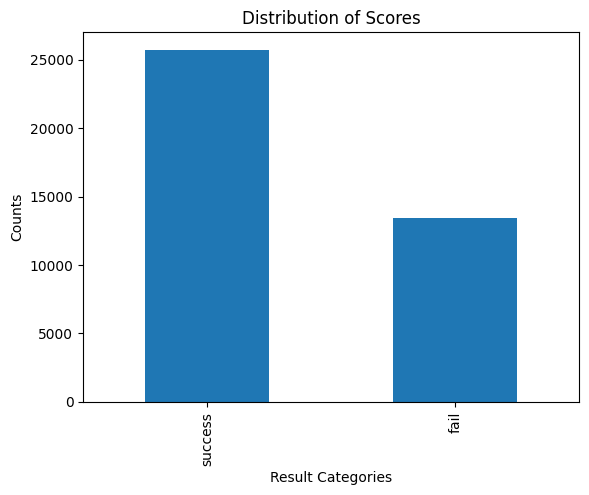

In [ ]:
actions_valuecounts = offensive_data["result_name"].value_counts()

#groupby("type_name")
actions_valuecounts.plot(kind='bar')

plt.title("Distribution of Scores")
plt.xlabel("Result Categories")
plt.ylabel("Counts")
plt.show()

In [ ]:
offensive_data[["time_seconds","start_x", "start_y","vaep_value"]].describe()

time_seconds       start_x       start_y    vaep_value
count  39150.000000  39150.000000  39150.000000  39150.000000
mean    1462.672878     16.379034     34.748261      0.127171
std      832.059342      9.592127     22.391611      0.248265
min        7.393468      0.000000      0.000000      0.000001
25%      740.704150      8.400000     10.880000      0.009811
50%     1468.893597     14.700000     35.360000      0.030219
75%     2189.405414     25.200000     57.800000      0.078057
max     3310.186437     34.650000     68.000000      1.016840

# 2 EDA

original eda

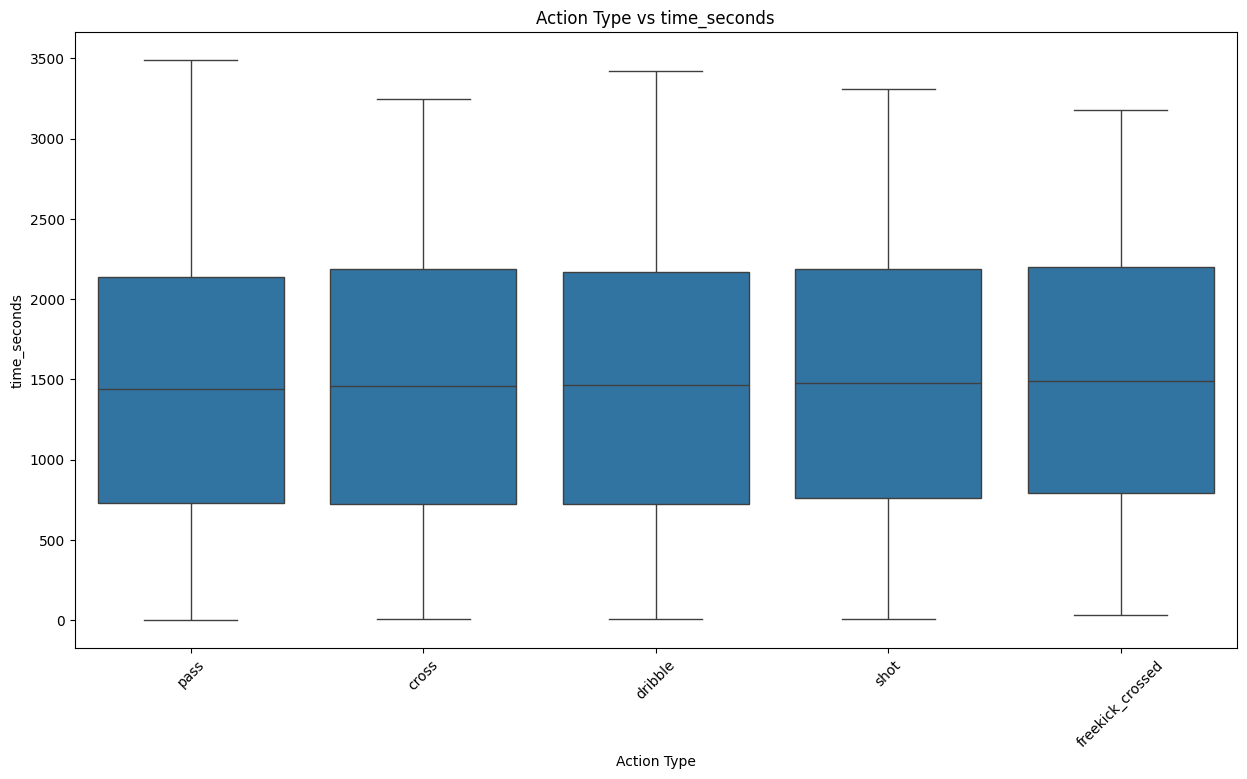

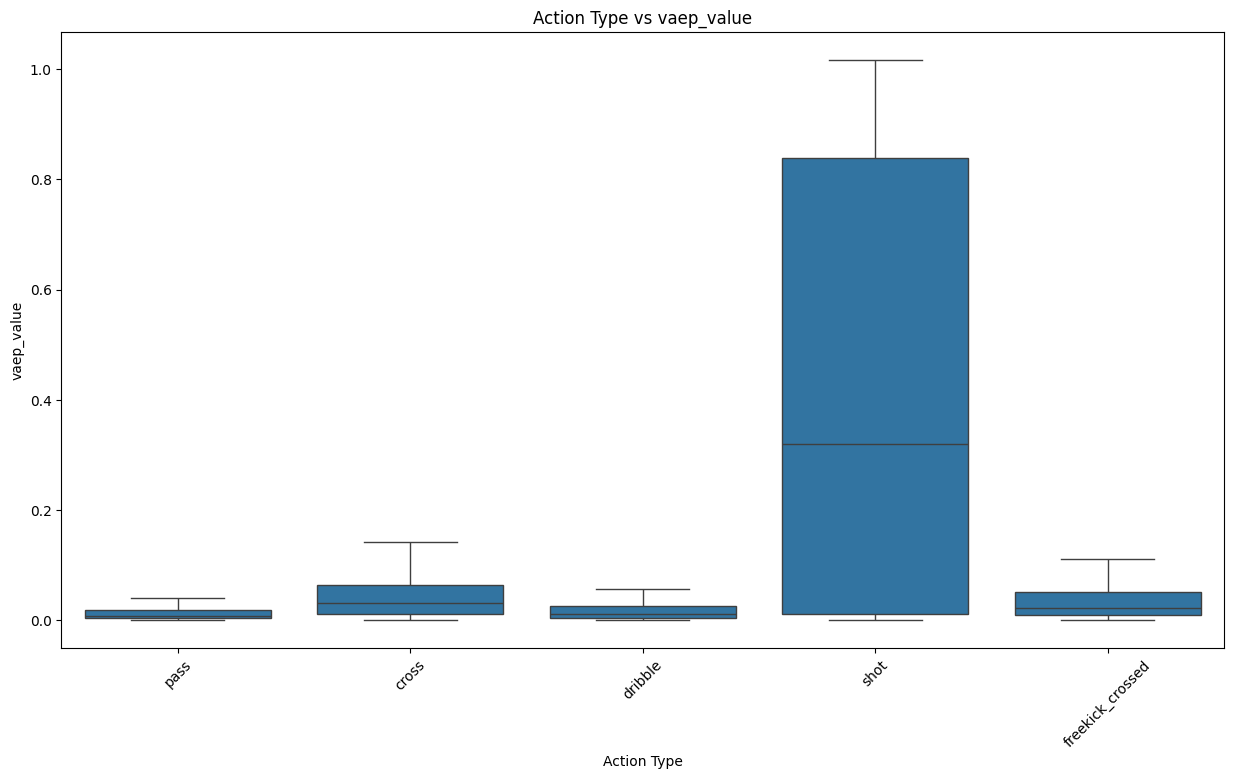

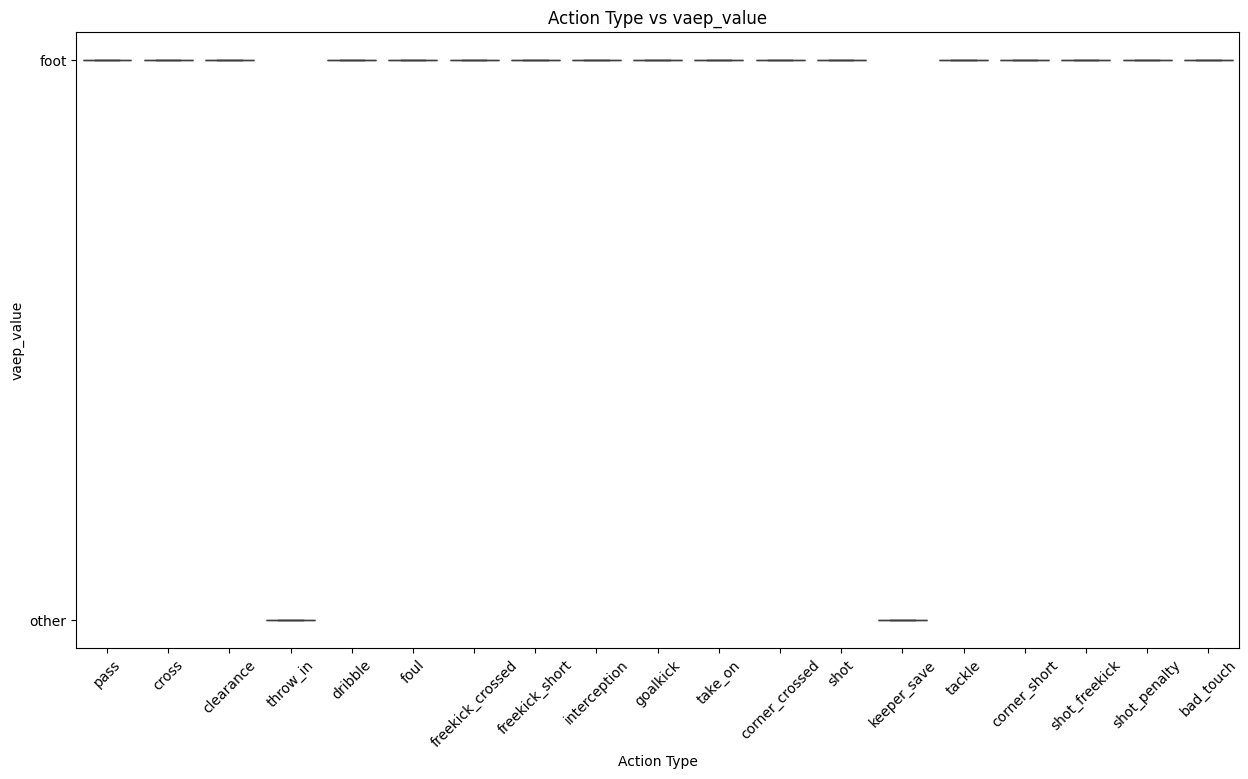

In [ ]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=offensive_data, x="type_name", y="time_seconds", showfliers=False)
plt.title("Action Type vs time_seconds")
plt.xlabel("Action Type")
plt.ylabel("time_seconds")
plt.xticks(rotation=45)
plt.show()


plt.figure(figsize=(15, 8))
sns.boxplot(data=offensive_data, x="type_name", y="vaep_value", showfliers=False)
plt.title("Action Type vs vaep_value")
plt.xlabel("Action Type")
plt.ylabel("vaep_value")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(15, 8))
sns.boxplot(data=actions, x="type_name", y="bodypart_name", showfliers=False)
plt.title("Action Type vs vaep_value")
plt.xlabel("Action Type")
plt.ylabel("vaep_value")
plt.xticks(rotation=45)
plt.show()

EDA using mplsoccer library

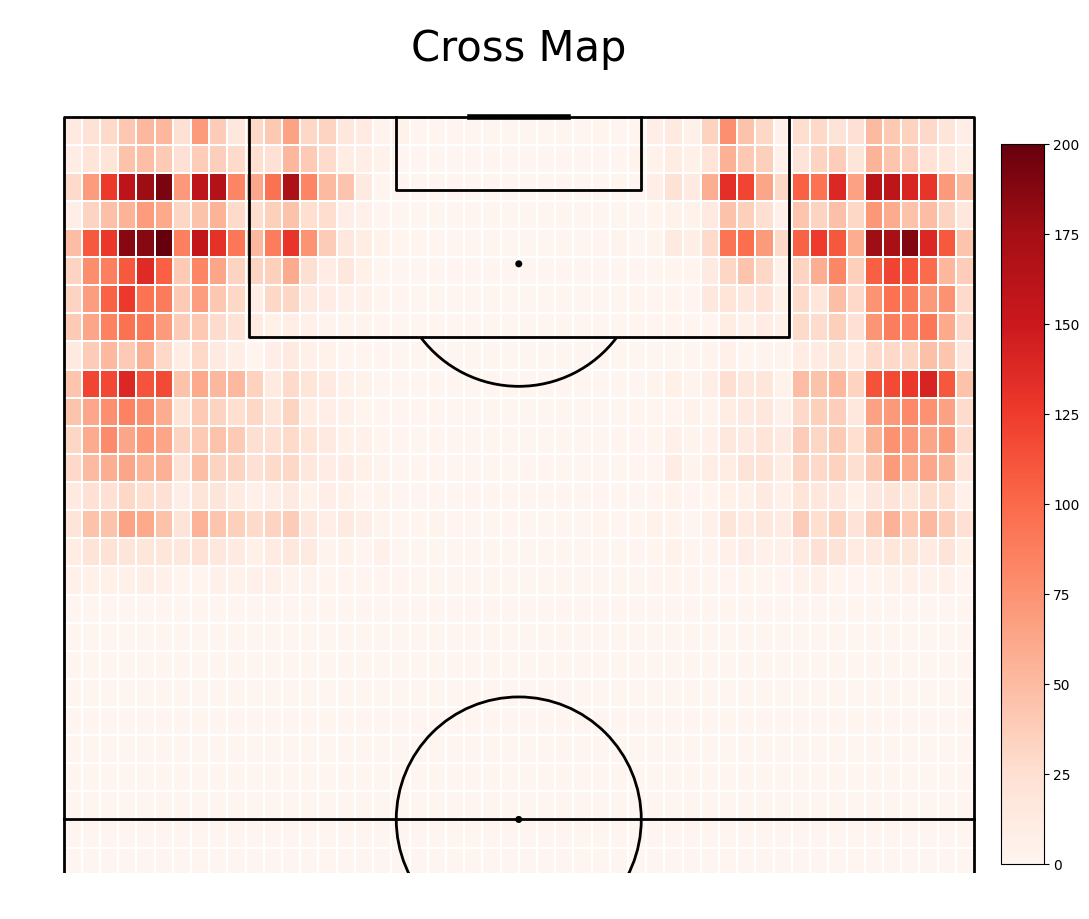

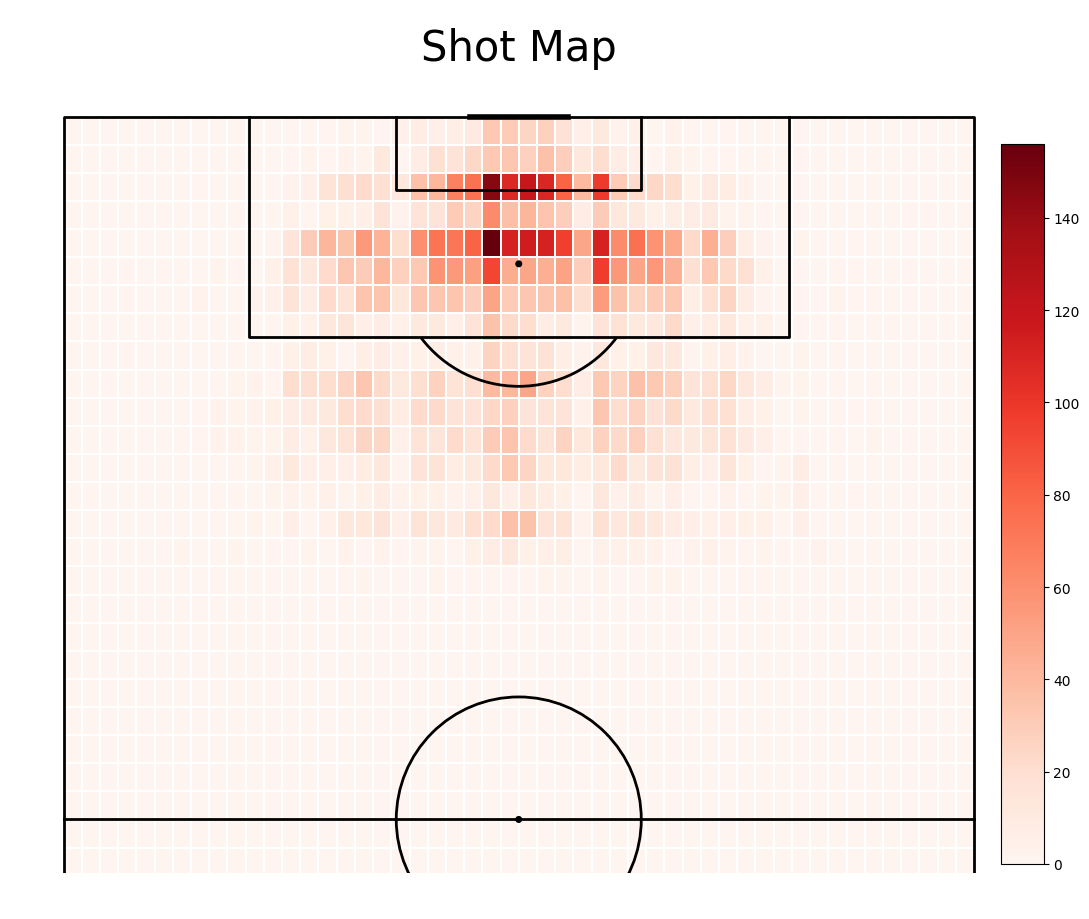

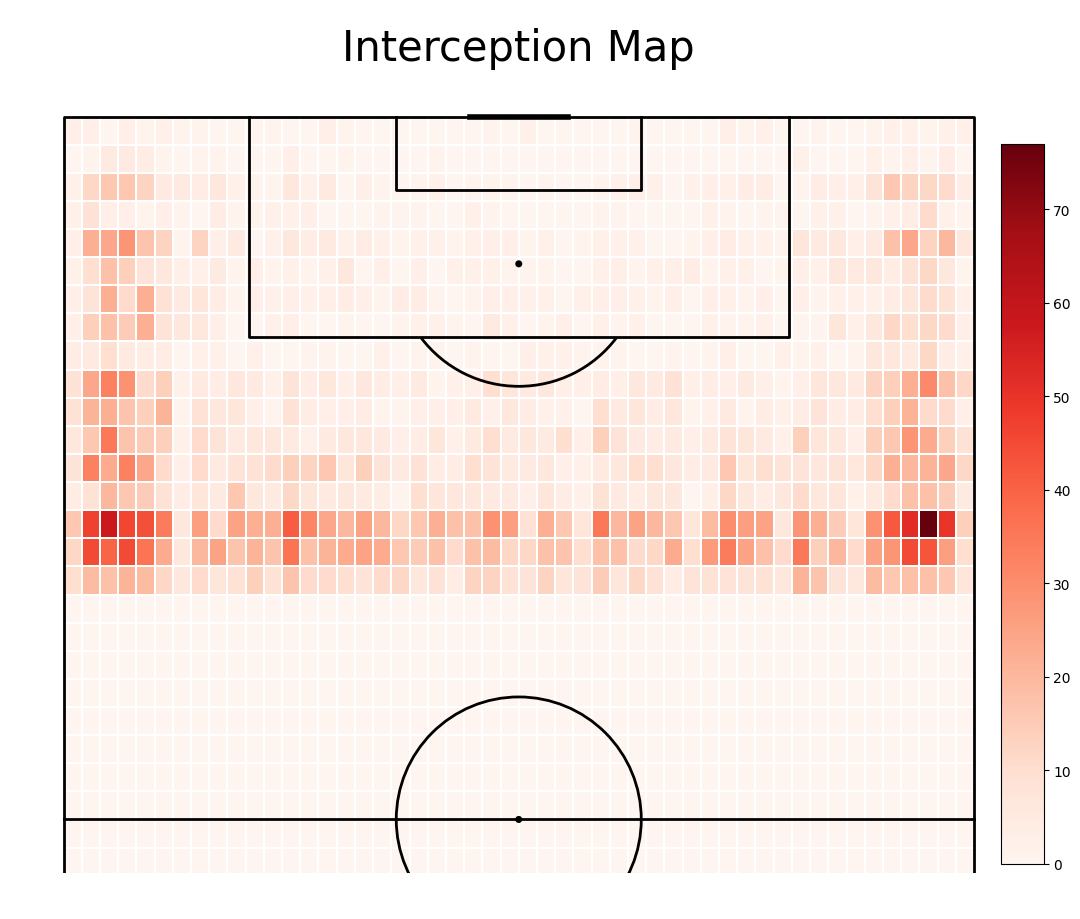

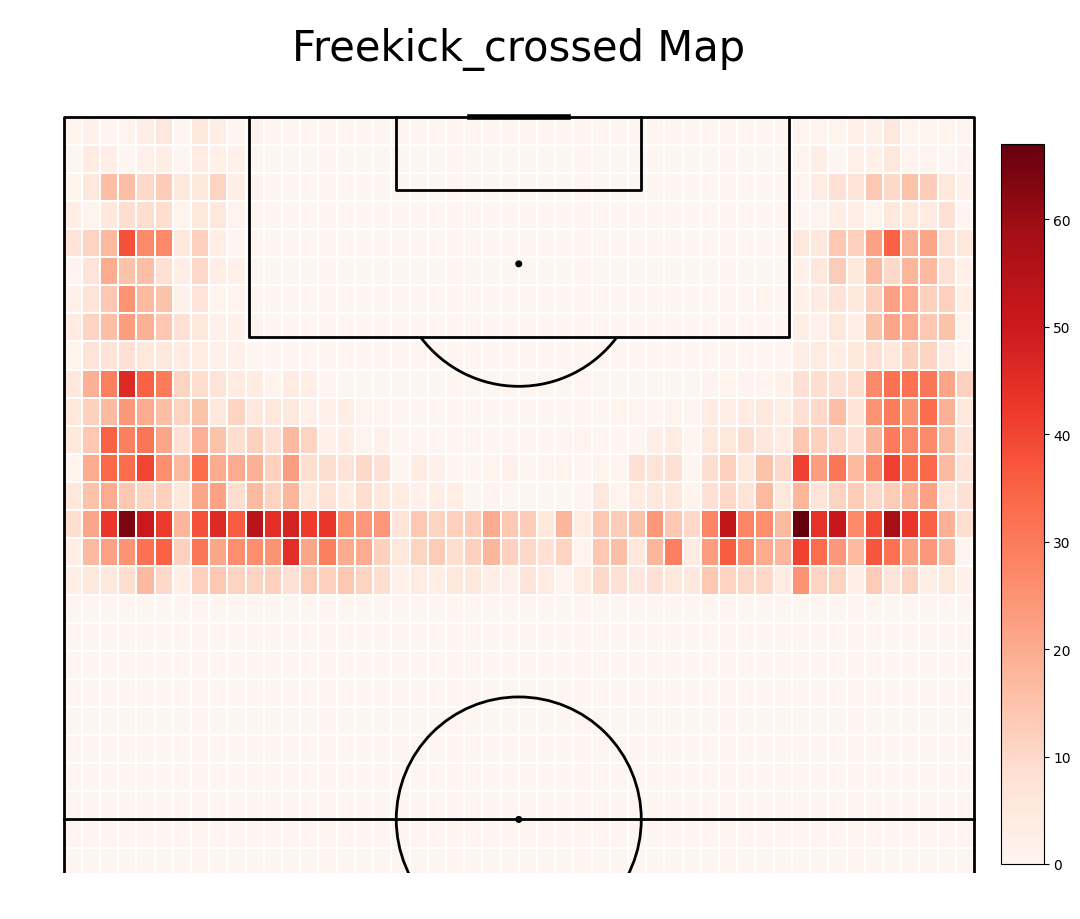

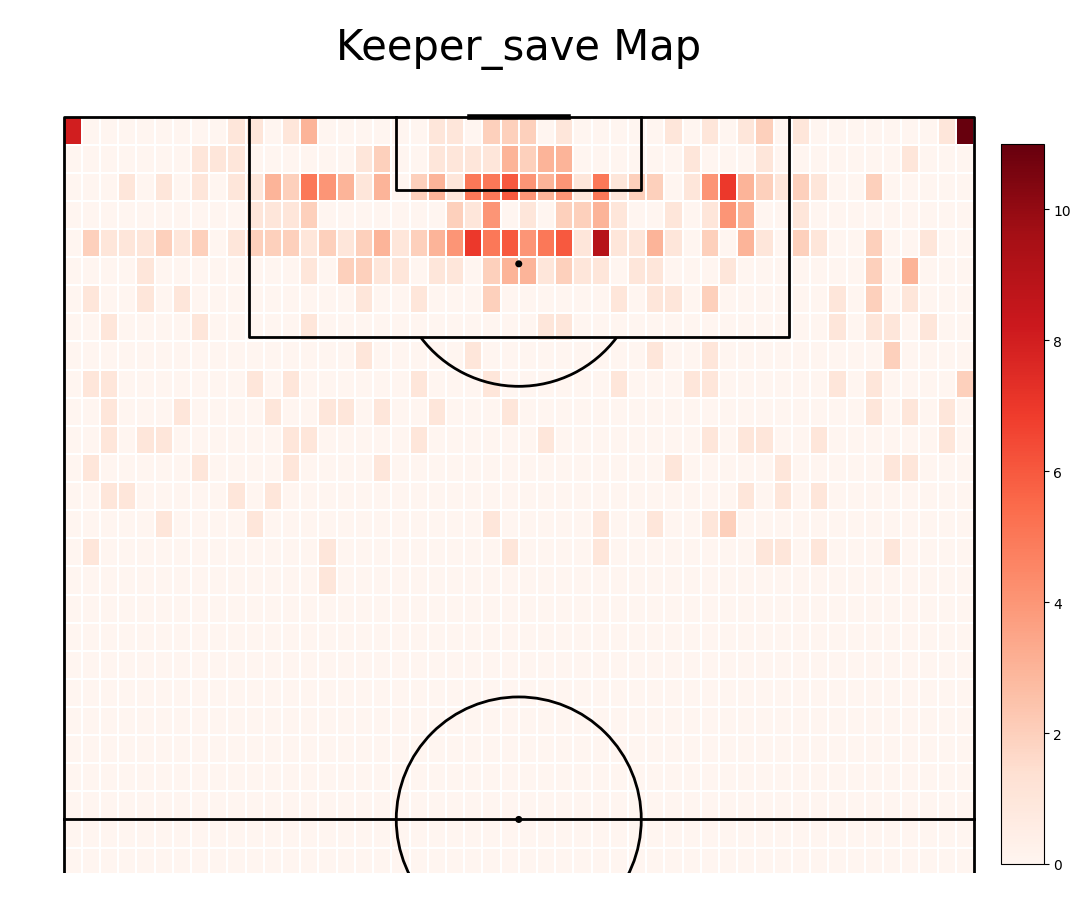

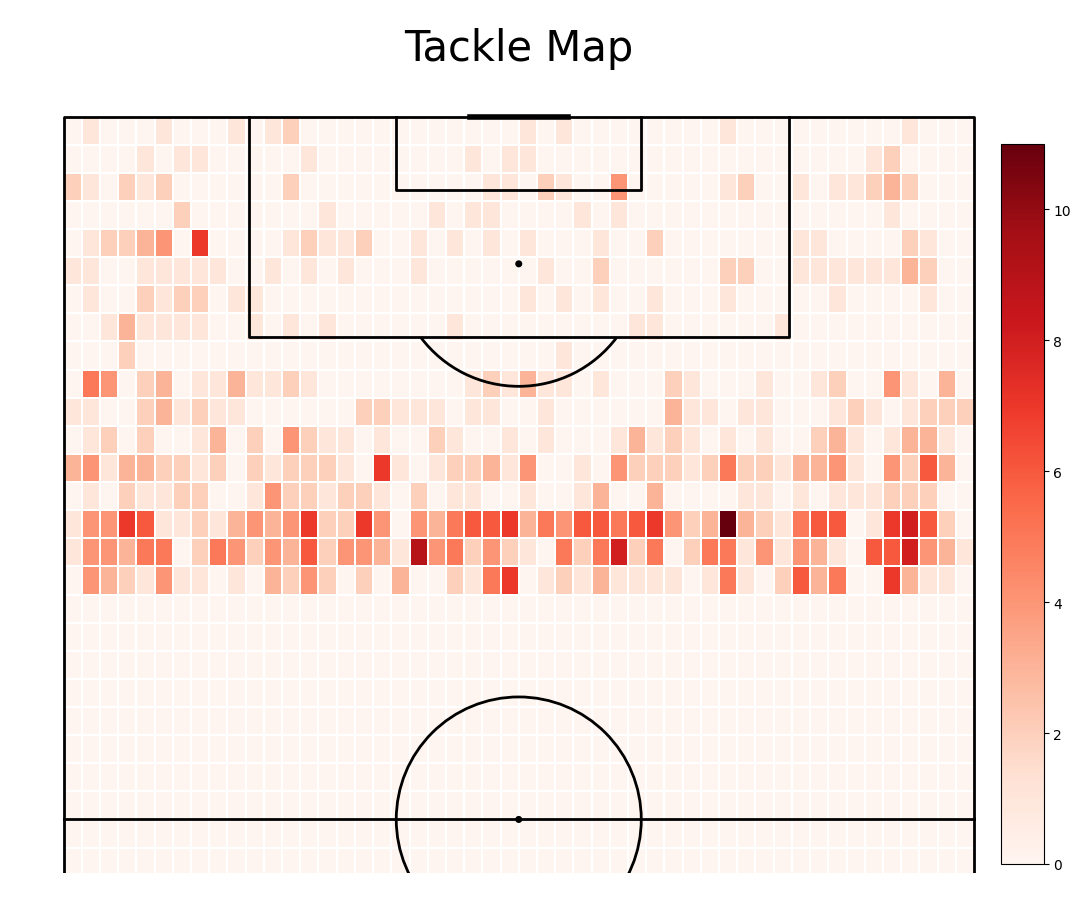

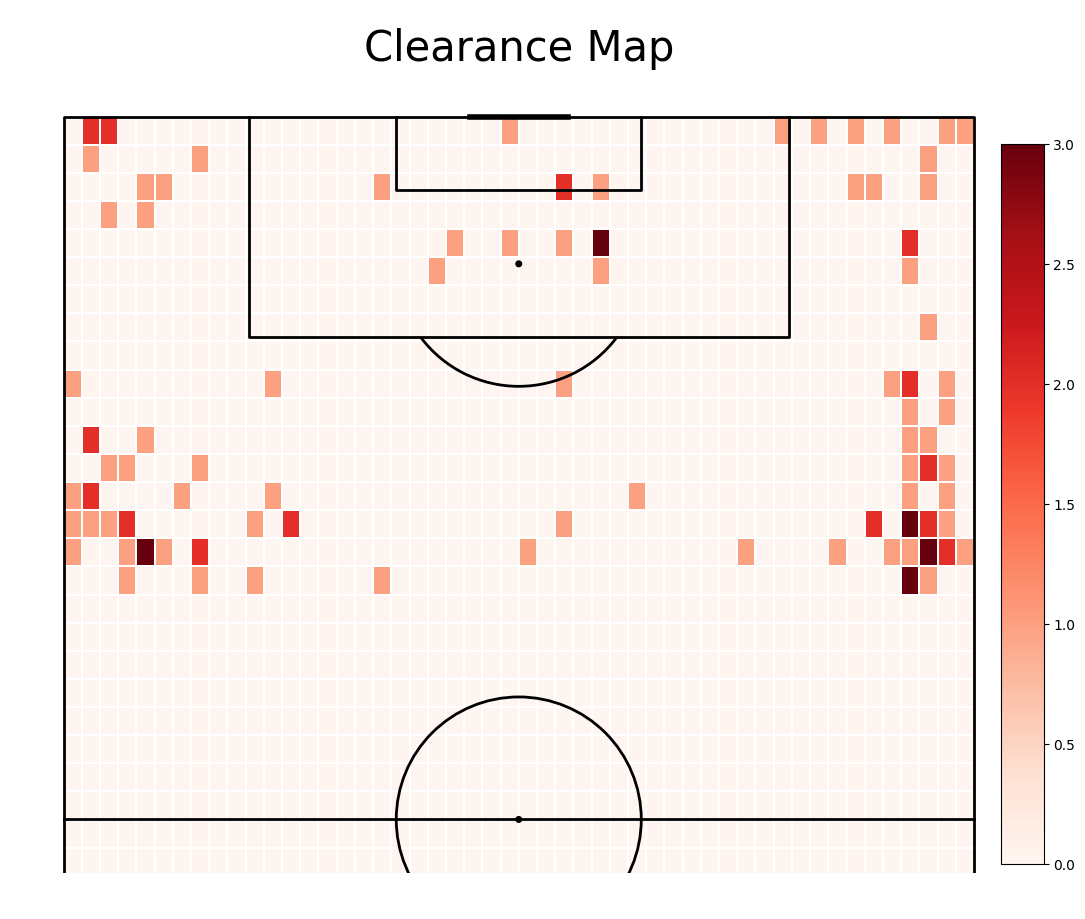

In [ ]:
unique_actions = offensive_data["type_name"].unique()

for action in unique_actions:
    # filtering specific feature
    action_data = offensive_data[offensive_data["type_name"] == action]


    # mplsoccer
    pitch = VerticalPitch(
        line_color='black',
        half=True,
        pitch_type='custom',
        pitch_length=105,
        pitch_width=68,
        line_zorder=2
    )
    fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                         endnote_height=0.04, title_space=0, endnote_space=0)

    # Heatmap
    bin_statistic = pitch.bin_statistic(105 - action_data["start_x"], action_data["start_y"], bins=(50, 50))

    # plotting
    pcm = pitch.heatmap(bin_statistic, ax=ax["pitch"], cmap='Reds', edgecolor='white', linewidth=0.01)
    ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
    cbar = plt.colorbar(pcm, cax=ax_cbar)

    # title of graphic
    fig.suptitle(f'{action.capitalize()} Map', fontsize=30)
    plt.show()

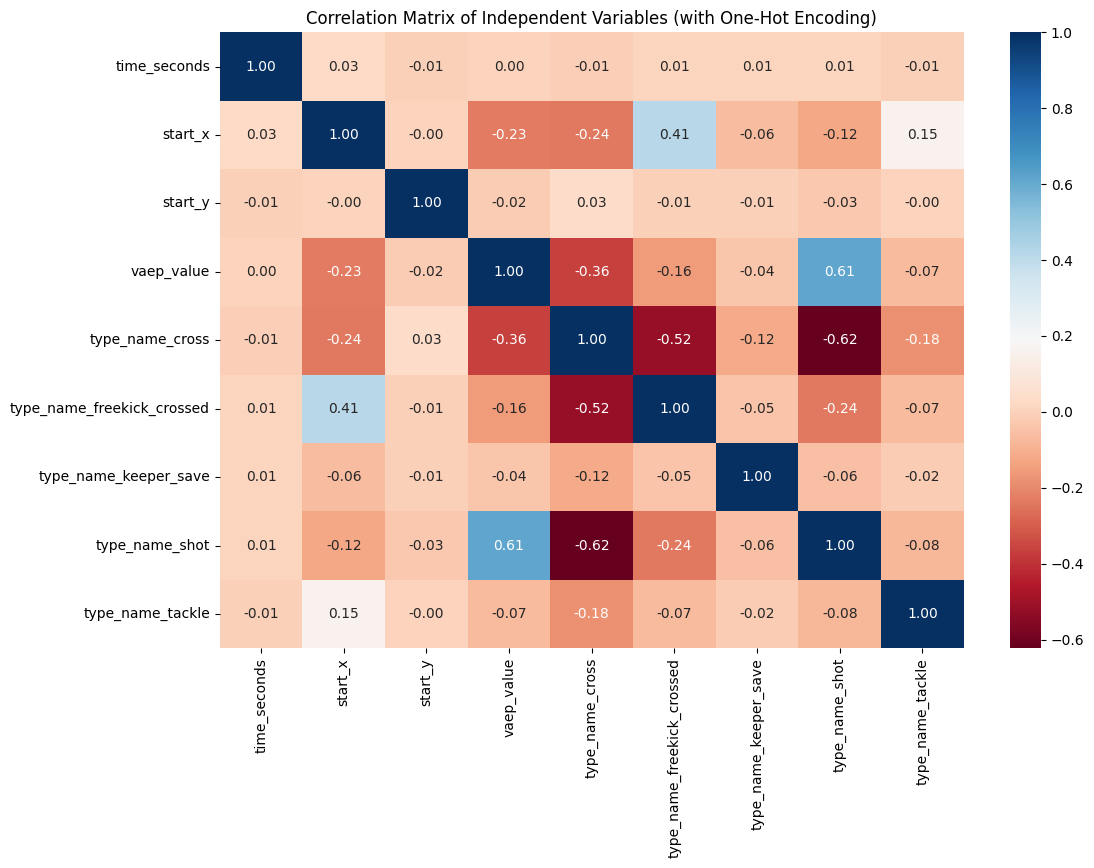

In [ ]:
# independent variable
independent_variables = offensive_data[["type_name", "time_seconds", "start_x", "start_y", "vaep_value"]]
independent_variables_encoded = pd.get_dummies(independent_variables, columns=["type_name"], drop_first=True)

# correlation
correlation_matrix = independent_variables_encoded.corr()

# cor heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="RdBu", fmt=".2f")
plt.title("Correlation Matrix of Independent Variables (with One-Hot Encoding)")
plt.show()

In [ ]:
data = offensive_data[["type_name", "start_x", "start_y", "vaep_value", "time_seconds", "result_name"]]
data.describe()

start_x       start_y    vaep_value  time_seconds
count  38734.000000  38734.000000  38734.000000  38734.000000
mean      16.442609     34.762547      0.128147   1462.206856
std        9.588625     22.443284      0.249341    832.117326
min        0.000000      0.000000      0.000001      7.393468
25%        8.400000     10.880000      0.009917    740.713589
50%       14.700000     35.360000      0.030424   1468.038689
75%       25.200000     57.800000      0.078575   2188.835735
max       34.650000     68.000000      1.016840   3310.186437

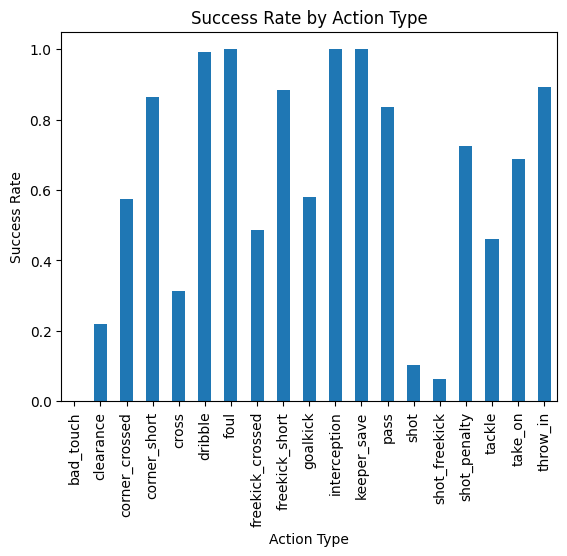

In [ ]:
success_rate = df.groupby("type_name")["result_name"].apply(
    lambda x: (x == "success").sum() / len(x)
)

success_rate.plot(kind="bar")
plt.title("Success Rate by Action Type")
plt.xlabel("Action Type")
plt.ylabel("Success Rate")
plt.show()

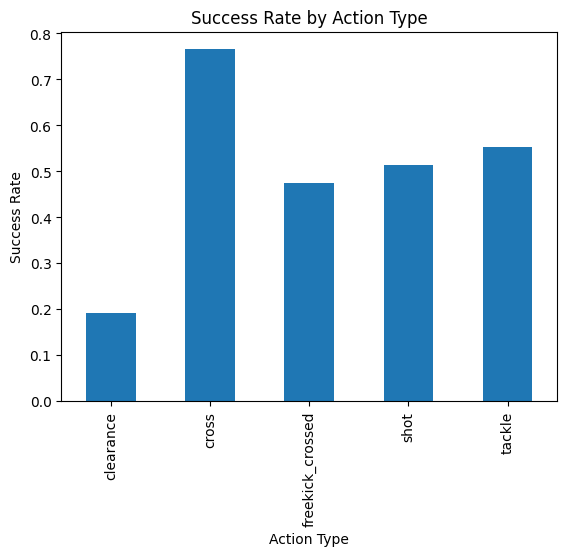

In [ ]:
success_rate = offensive_data.groupby("type_name")["result_name"].apply(
    lambda x: (x == "success").sum() / len(x)
)

success_rate.plot(kind="bar")
plt.title("Success Rate by Action Type")
plt.xlabel("Action Type")
plt.ylabel("Success Rate")
plt.show()

# 3 Modeling (Logistic, RandomForest, XGBoost, LightGBM)



## Data Preprocessing

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

# preparation of data
data = offensive_data[["type_name", "start_x", "start_y", "vaep_value", "time_seconds", "result_name"]]
data['result'] = data['result_name'].apply(lambda x: 1 if x == 'success' else 0)
data_encoded = pd.get_dummies(data, columns=["type_name"])

X = data_encoded.drop(columns=["result_name", "result"])
y = data_encoded["result"]

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# undersampling
undersampler = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# data scaling
scaler = StandardScaler()
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)  # using data after undersampling
X_test_scaled = scaler.transform(X_test)  

<ipython-input-26-b1ae1a56978d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['result'] = data['result_name'].apply(lambda x: 1 if x == 'success' else 0)


In [ ]:
X_train_resampled_scaled.shape

(41164, 10)

In [ ]:
y_train_resampled.shape

(41164,)

## 1 LogisticRegression

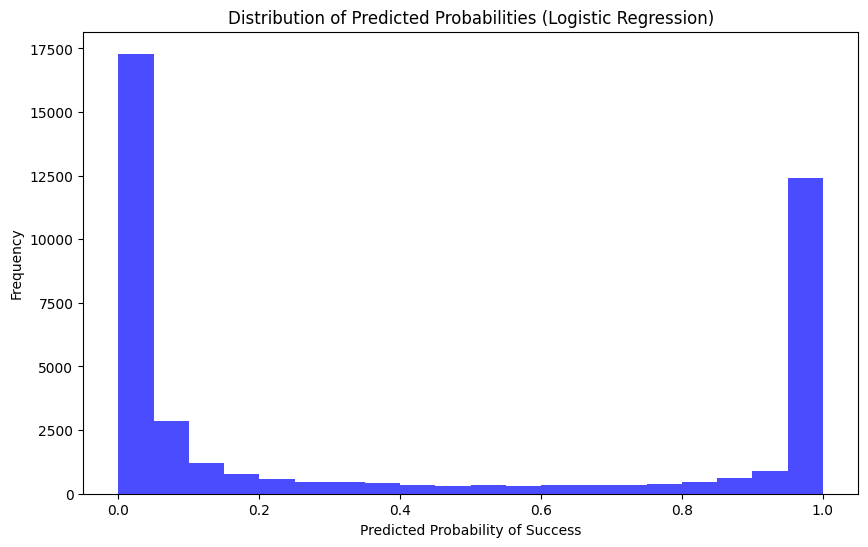


Sample Predicted Probabilities (Logistic Regression):
[9.99678550e-01 5.48479232e-02 9.30104894e-01 9.99968780e-01
 1.00000000e+00 9.60866922e-01 9.84849540e-01 4.48686523e-16
 1.00000000e+00 8.84157095e-01]

--- Logistic Regression ---
Sample Predicted Probabilities (Logistic Regression):
[7.33660562e-04 1.19544625e-15 7.99842291e-01 1.00000000e+00
 3.32836543e-01 1.83647480e-03 2.76288327e-15 4.52548764e-04
 1.01116195e-01 1.00000000e+00]
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.95      0.79      2685
           1       0.96      0.77      0.85      5145

    accuracy                           0.83      7830
   macro avg       0.82      0.86      0.82      7830
weighted avg       0.87      0.83      0.83      7830


Brier Score for Logistic Regression: 0.1346


In [ ]:
from sklearn.metrics import brier_score_loss, classification_report
from tqdm import tqdm

# Train model: the example of LogisticRegression
log_reg = LogisticRegression(max_iter=100, random_state=42)
log_reg.fit(X_train_resampled, y_train_resampled)

# predict goal probability
y_pred_proba_log_reg = log_reg.predict_proba(X_train_resampled_scaled)[:, 1]  # probability of class 1 (Success)

# check distribution of success
plt.figure(figsize=(10, 6))
plt.hist(y_pred_proba_log_reg, bins=20, color='blue', alpha=0.7)
plt.xlabel("Predicted Probability of Success")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probabilities (Logistic Regression)")
plt.show()

# check few of sample
print("\nSample Predicted Probabilities (Logistic Regression):")
print(y_pred_proba_log_reg[:10])

# eval and result (predict only on test data)
y_pred_proba_log_reg = log_reg.predict_proba(X_test_scaled)[:, 1]  # success probabilty prediction using test data

# print result
print("\n--- Logistic Regression ---")
print("Sample Predicted Probabilities (Logistic Regression):")
print(y_pred_proba_log_reg[:10])  # print sample of prediction

# using binary result
y_pred_log_reg = (y_pred_proba_log_reg > 0.5).astype(int)
print("Classification Report:")
print(classification_report(y_test, y_pred_log_reg))

# Brier Score predict (quality of probability of prediction)
# using size of y_test and y_pred_proba_log_reg
brier_score = brier_score_loss(y_test, y_pred_proba_log_reg)
print(f"\nBrier Score for Logistic Regression: {brier_score:.4f}")

## 2 RandomForest

Training Random Forest: 100%|██████████| 100/100 [00:08<00:00, 11.22tree/s]


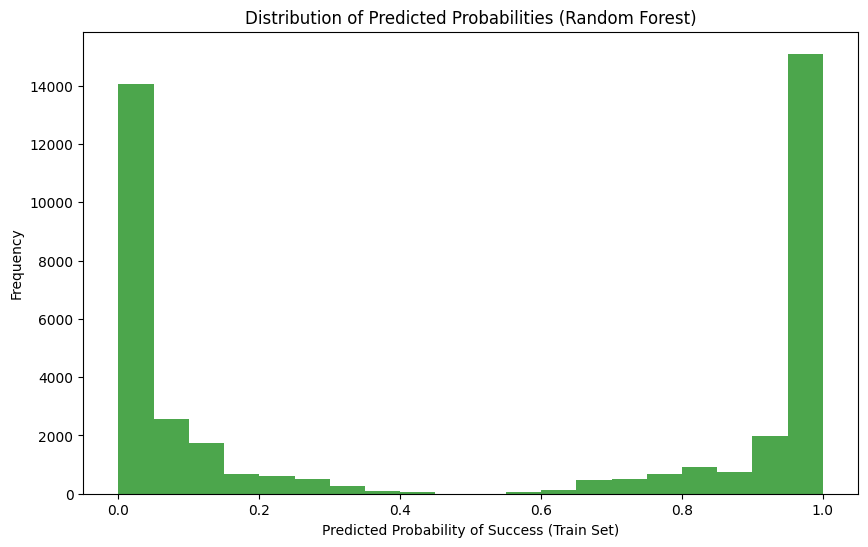


Sample Predicted Probabilities (Random Forest - Train Set):
[1.   0.18 0.92 1.   1.   0.97 1.   0.   1.   0.97]

--- Random Forest ---
Sample Predicted Probabilities (Random Forest - Test Set):
[0.17 0.   0.86 1.   0.77 0.14 0.   0.03 0.33 1.  ]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.84      2685
           1       0.92      0.90      0.91      5145

    accuracy                           0.88      7830
   macro avg       0.87      0.88      0.87      7830
weighted avg       0.89      0.88      0.89      7830


Brier Score for Random Forest: 0.0831


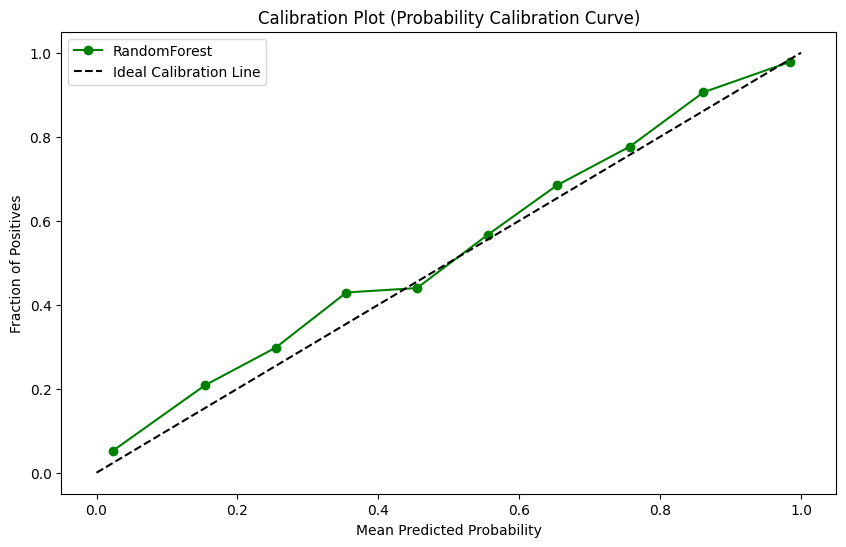

In [ ]:
from sklearn.calibration import calibration_curve

# Random Forest  (step by step train n_estimators)
n_estimators = 100
rf_model = RandomForestClassifier(
    n_estimators=1,  # start with 1 tree
    random_state=42,
    class_weight="balanced",
    warm_start=True  # train step by step
)

# track current state using tqdm library
with tqdm(total=n_estimators, desc="Training Random Forest", unit="tree") as pbar:
    for i in range(1, n_estimators + 1):

        rf_model.set_params(n_estimators=i)

        rf_model.fit(X_train_resampled_scaled, y_train_resampled)

        # tqdm update
        pbar.update(1)

# prediction of success probability (using train data)
y_pred_proba_rf_train = rf_model.predict_proba(X_train_resampled_scaled)[:, 1]  # probability of class 1 (success probability)

# distribution of success probability
plt.figure(figsize=(10, 6))
plt.hist(y_pred_proba_rf_train, bins=20, color='green', alpha=0.7)
plt.xlabel("Predicted Probability of Success (Train Set)")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probabilities (Random Forest)")
plt.show()

# Check with sample (using train data)
print("\nSample Predicted Probabilities (Random Forest - Train Set):")
print(y_pred_proba_rf_train[:10])

# predict and eval (only using test data)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]  #predict with test data

# Print result
print("\n--- Random Forest ---")
print("Sample Predicted Probabilities (Random Forest - Test Set):")
print(y_pred_proba_rf[:10])  # print sample

# convert to binary result
y_pred_rf = (y_pred_proba_rf > 0.5).astype(int)
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Brier Scor (quality of prediction)
brier_score_rf = brier_score_loss(y_test, y_pred_proba_rf)
print(f"\nBrier Score for Random Forest: {brier_score_rf:.4f}")

# Calibration Curve 
prob_true_rf, prob_pred_rf = calibration_curve(y_test, y_pred_proba_rf, n_bins=10, pos_label=1)

plt.figure(figsize=(10, 6))
plt.plot(prob_pred_rf, prob_true_rf, marker='o', color='green', label="RandomForest")
plt.plot([0, 1], [0, 1], linestyle='--', color='k', label="Ideal Calibration Line")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Plot (Probability Calibration Curve)")
plt.legend()
plt.show()

## 3 XGBoost

Training XGBoost: 100%|██████████| 1/1 [00:00<00:00,  1.66iteration/s]


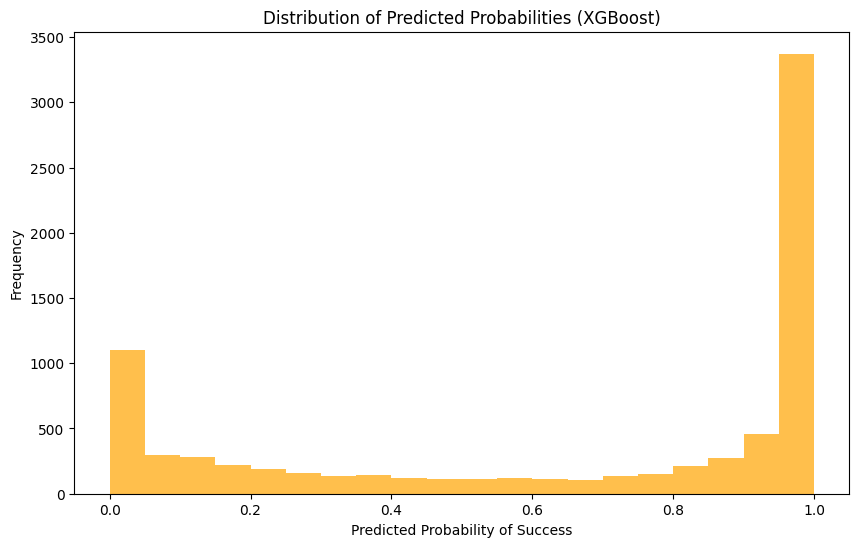


Sample Predicted Probabilities (XGBoost):
[1.2324371e-01 2.9810221e-04 9.2863488e-01 9.8862177e-01 9.1126519e-01
 1.4623345e-01 9.5982621e-05 3.7156831e-02 2.9200250e-01 9.9884439e-01]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.84      2685
           1       0.92      0.91      0.91      5145

    accuracy                           0.89      7830
   macro avg       0.87      0.88      0.88      7830
weighted avg       0.89      0.89      0.89      7830


Brier Score for XGBoost: 0.0813


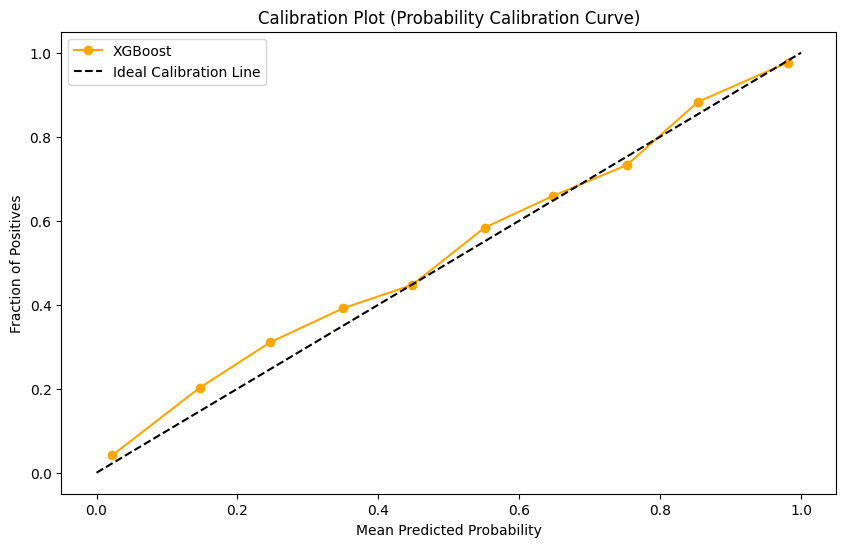

In [ ]:
# XGBoost 
xgb_model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric="logloss")

# train model (using tqdm)
with tqdm(total=1, desc="Training XGBoost", unit="iteration") as pbar:
    # train model
    xgb_model.fit(X_train_resampled_scaled, y_train_resampled, verbose=False)
    # tqdm 
    pbar.update(1)

# success probability after test
y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

# distribution of success
plt.figure(figsize=(10, 6))
plt.hist(y_pred_proba_xgb, bins=20, color='orange', alpha=0.7)
plt.xlabel("Predicted Probability of Success")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probabilities (XGBoost)")
plt.show()

# check
print("\nSample Predicted Probabilities (XGBoost):")
print(y_pred_proba_xgb[:10])

# combine to binary classification result
y_pred_xgb = (y_pred_proba_xgb > 0.5).astype(int)
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# Brier Score 
brier_score_xgb = brier_score_loss(y_test, y_pred_proba_xgb)
print(f"\nBrier Score for XGBoost: {brier_score_xgb:.4f}")

# Calibration Curve 
prob_true_xgb, prob_pred_xgb = calibration_curve(y_test, y_pred_proba_xgb, n_bins=10, pos_label=1)

plt.figure(figsize=(10, 6))
plt.plot(prob_pred_xgb, prob_true_xgb, marker='o', color='orange', label="XGBoost")
plt.plot([0, 1], [0, 1], linestyle='--', color='k', label="Ideal Calibration Line")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Plot (Probability Calibration Curve)")
plt.legend()
plt.show()

## 4 LightGBM

Training LightGBM:   1%|          | 1/100 [00:00<00:14,  6.87iteration/s]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10
[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[L

Training LightGBM:   6%|▌         | 6/100 [00:00<00:06, 14.20iteration/s]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10
[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10
[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing

Training LightGBM:   8%|▊         | 8/100 [00:00<00:07, 12.11iteration/s]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10
[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  10%|█         | 10/100 [00:00<00:08, 10.04iteration/s]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10
[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  12%|█▏        | 12/100 [00:01<00:11,  7.76iteration/s]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  13%|█▎        | 13/100 [00:01<00:12,  6.74iteration/s]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  14%|█▍        | 14/100 [00:01<00:14,  5.97iteration/s]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  15%|█▌        | 15/100 [00:02<00:15,  5.32iteration/s]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  16%|█▌        | 16/100 [00:02<00:18,  4.58iteration/s]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  17%|█▋        | 17/100 [00:02<00:20,  4.00iteration/s]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  18%|█▊        | 18/100 [00:02<00:22,  3.67iteration/s]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  19%|█▉        | 19/100 [00:03<00:24,  3.25iteration/s]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  20%|██        | 20/100 [00:03<00:27,  2.95iteration/s]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  21%|██        | 21/100 [00:04<00:29,  2.70iteration/s]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  22%|██▏       | 22/100 [00:04<00:31,  2.45iteration/s]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  23%|██▎       | 23/100 [00:05<00:33,  2.27iteration/s]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  24%|██▍       | 24/100 [00:05<00:36,  2.08iteration/s]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  25%|██▌       | 25/100 [00:06<00:39,  1.90iteration/s]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  26%|██▌       | 26/100 [00:07<00:42,  1.74iteration/s]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  27%|██▋       | 27/100 [00:07<00:44,  1.62iteration/s]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  28%|██▊       | 28/100 [00:08<00:47,  1.52iteration/s]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10
[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  29%|██▉       | 29/100 [00:09<01:01,  1.16iteration/s]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  30%|███       | 30/100 [00:11<01:21,  1.17s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  32%|███▏      | 32/100 [00:14<01:32,  1.37s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  33%|███▎      | 33/100 [00:15<01:24,  1.26s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  34%|███▍      | 34/100 [00:17<01:19,  1.21s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10
[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  35%|███▌      | 35/100 [00:18<01:17,  1.20s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  36%|███▌      | 36/100 [00:19<01:16,  1.20s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  37%|███▋      | 37/100 [00:20<01:16,  1.22s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  38%|███▊      | 38/100 [00:22<01:17,  1.26s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  39%|███▉      | 39/100 [00:23<01:20,  1.31s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  40%|████      | 40/100 [00:25<01:33,  1.56s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.164957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  41%|████      | 41/100 [00:31<02:44,  2.78s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  42%|████▏     | 42/100 [00:35<03:00,  3.11s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  43%|████▎     | 43/100 [00:42<04:12,  4.43s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  44%|████▍     | 44/100 [00:48<04:36,  4.93s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  45%|████▌     | 45/100 [00:51<03:48,  4.15s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  46%|████▌     | 46/100 [00:53<03:15,  3.62s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  47%|████▋     | 47/100 [00:56<02:54,  3.30s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  48%|████▊     | 48/100 [01:01<03:21,  3.87s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  49%|████▉     | 49/100 [01:04<03:05,  3.64s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  50%|█████     | 50/100 [01:09<03:25,  4.11s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  51%|█████     | 51/100 [01:17<04:19,  5.29s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  52%|█████▏    | 52/100 [01:22<04:07,  5.17s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  53%|█████▎    | 53/100 [01:25<03:38,  4.65s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  54%|█████▍    | 54/100 [01:32<04:00,  5.22s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  55%|█████▌    | 55/100 [01:36<03:33,  4.75s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  56%|█████▌    | 56/100 [01:39<03:16,  4.47s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  57%|█████▋    | 57/100 [01:50<04:30,  6.28s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  58%|█████▊    | 58/100 [01:58<04:49,  6.89s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  59%|█████▉    | 59/100 [02:05<04:46,  7.00s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  60%|██████    | 60/100 [02:10<04:07,  6.20s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.098691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  61%|██████    | 61/100 [02:16<04:01,  6.18s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  62%|██████▏   | 62/100 [02:25<04:29,  7.09s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  63%|██████▎   | 63/100 [02:35<04:48,  7.80s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  64%|██████▍   | 64/100 [02:40<04:10,  6.96s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  65%|██████▌   | 65/100 [02:45<03:46,  6.47s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  66%|██████▌   | 66/100 [02:54<04:03,  7.17s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.159531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  67%|██████▋   | 67/100 [03:06<04:49,  8.76s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  68%|██████▊   | 68/100 [03:12<04:09,  7.80s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  69%|██████▉   | 69/100 [03:20<04:06,  7.96s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  70%|███████   | 70/100 [03:26<03:42,  7.41s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  71%|███████   | 71/100 [03:39<04:20,  8.97s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  72%|███████▏  | 72/100 [03:47<04:01,  8.63s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  73%|███████▎  | 73/100 [03:56<03:56,  8.77s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  74%|███████▍  | 74/100 [04:03<03:34,  8.27s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  75%|███████▌  | 75/100 [04:17<04:06,  9.88s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  76%|███████▌  | 76/100 [04:31<04:29, 11.25s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  77%|███████▋  | 77/100 [04:47<04:52, 12.72s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  78%|███████▊  | 78/100 [05:02<04:54, 13.40s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.169692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  79%|███████▉  | 79/100 [05:13<04:22, 12.51s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  80%|████████  | 80/100 [05:28<04:30, 13.55s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  81%|████████  | 81/100 [05:37<03:48, 12.04s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  82%|████████▏ | 82/100 [05:48<03:30, 11.69s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  83%|████████▎ | 83/100 [06:08<04:03, 14.33s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  84%|████████▍ | 84/100 [06:20<03:34, 13.39s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  85%|████████▌ | 85/100 [06:34<03:24, 13.60s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  86%|████████▌ | 86/100 [06:47<03:10, 13.64s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  87%|████████▋ | 87/100 [06:57<02:40, 12.34s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  88%|████████▊ | 88/100 [07:15<02:50, 14.20s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  89%|████████▉ | 89/100 [07:26<02:24, 13.15s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  90%|█████████ | 90/100 [07:41<02:18, 13.81s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.149668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  91%|█████████ | 91/100 [08:07<02:35, 17.23s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.161491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  92%|█████████▏| 92/100 [08:26<02:23, 17.93s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  93%|█████████▎| 93/100 [08:39<01:55, 16.53s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  94%|█████████▍| 94/100 [08:56<01:40, 16.67s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  95%|█████████▌| 95/100 [09:12<01:21, 16.25s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  96%|█████████▌| 96/100 [09:28<01:04, 16.17s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  97%|█████████▋| 97/100 [09:46<00:50, 16.82s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  98%|█████████▊| 98/100 [10:02<00:33, 16.51s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM:  99%|█████████▉| 99/100 [10:21<00:17, 17.29s/iteration]

[LightGBM] [Info] Number of positive: 20582, number of negative: 20582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 41164, number of used features: 10


Training LightGBM: 100%|██████████| 100/100 [10:37<00:00,  6.38s/iteration]


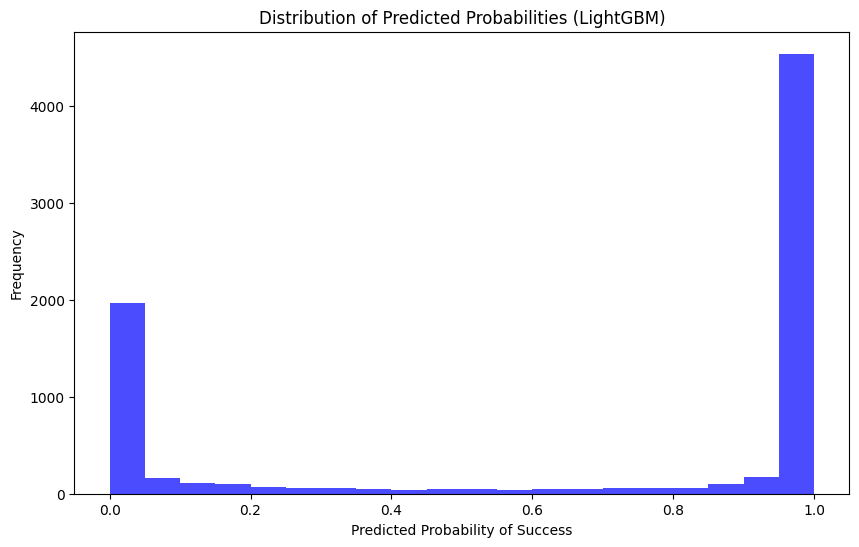


Sample Predicted Probabilities (LightGBM):
[3.05064885e-02 1.48615129e-08 9.98155596e-01 9.99979102e-01
 9.99829882e-01 2.11945350e-02 1.81363875e-09 2.09448925e-03
 8.54596207e-01 9.99973634e-01]

Brier Score for LightGBM: 0.1040


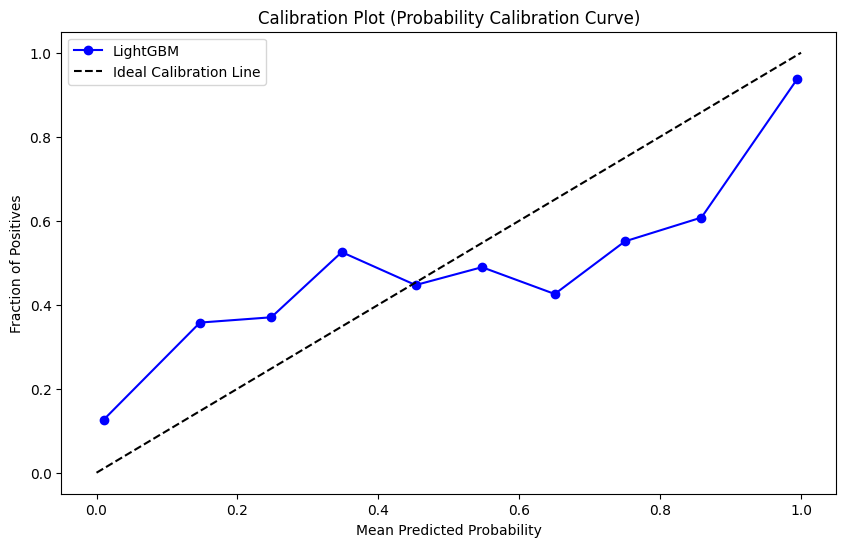

In [ ]:
# LightGBM 
params = {
    'objective': 'binary',  # binary classification
    'metric': 'binary_logloss',  # eval
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'seed': 42
}

n_estimators = 100  # #of boosting
train_data = lgb.Dataset(X_train_resampled_scaled, label=y_train_resampled, free_raw_data=False)
valid_data = lgb.Dataset(X_test_scaled, label=y_test, reference=train_data, free_raw_data=False)


with tqdm(total=n_estimators, desc="Training LightGBM", unit="iteration") as pbar:
    lgb_model = None  # 
    for i in range(1, n_estimators + 1):
        params['num_iterations'] = i  
        lgb_model = lgb.train(
            params,
            train_data,
            valid_sets=[valid_data],
            keep_training_booster=True if lgb_model is None else False,  
            init_model=lgb_model  
        )
        pbar.update(1)  


y_pred_proba_lgb = lgb_model.predict(X_test_scaled)


plt.figure(figsize=(10, 6))
plt.hist(y_pred_proba_lgb, bins=20, color='blue', alpha=0.7)
plt.xlabel("Predicted Probability of Success")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probabilities (LightGBM)")
plt.show()


print("\nSample Predicted Probabilities (LightGBM):")
print(y_pred_proba_lgb[:10])

# Brier Score 
brier_score_lgb = brier_score_loss(y_test, y_pred_proba_lgb)
print(f"\nBrier Score for LightGBM: {brier_score_lgb:.4f}")

# Calibration Curve 
prob_true_lgb, prob_pred_lgb = calibration_curve(y_test, y_pred_proba_lgb, n_bins=10, pos_label=1)

plt.figure(figsize=(10, 6))
plt.plot(prob_pred_lgb, prob_true_lgb, marker='o', color='blue', label="LightGBM")
plt.plot([0, 1], [0, 1], linestyle='--', color='k', label="Ideal Calibration Line")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Plot (Probability Calibration Curve)")
plt.legend()
plt.show()

# Evaluate

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, brier_score_loss, classification_report

# result of each model
models = {
    "Logistic Regression": y_pred_proba_log_reg,
    "Random Forest": y_pred_proba_rf,
    "XGBoost": y_pred_proba_xgb,
    "LightGBM": y_pred_proba_lgb
}

# reset dictionary 
model_performance = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1 Score": [],
    "Brier Score": []
}

# eval and save
for model_name, y_pred_proba in models.items():
    # convert to binary probability (classify by 0.5)
    y_pred = (y_pred_proba > 0.5).astype(int)

    # eval 
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=1)
    recall = recall_score(y_test, y_pred, zero_division=1)
    f1 = f1_score(y_test, y_pred, zero_division=1)
    brier_score = brier_score_loss(y_test, y_pred_proba)

    # save
    model_performance["Model"].append(model_name)
    model_performance["Accuracy"].append(accuracy)
    model_performance["Precision"].append(precision)
    model_performance["Recall"].append(recall)
    model_performance["F1 Score"].append(f1)
    model_performance["Brier Score"].append(brier_score)

# save to dataframe
performance_df = pd.DataFrame(model_performance)

# print
print("\nModel Performance Comparison:")
print(performance_df)


Model Performance Comparison:
                 Model  Accuracy  Precision    Recall  F1 Score  Brier Score
0  Logistic Regression  0.828225   0.964775  0.766569  0.854327     0.134616
1        Random Forest  0.884291   0.924494  0.897182  0.910633     0.083105
2              XGBoost  0.887484   0.921844  0.905539  0.913619     0.081266
3             LightGBM  0.872797   0.901025  0.905928  0.903470     0.103967



Brier Score for Logistic Regression: 0.1346

Brier Score for Random Forest: 0.0831

Brier Score for XGBoost: 0.0813

Brier Score for LightGBM: 0.1040


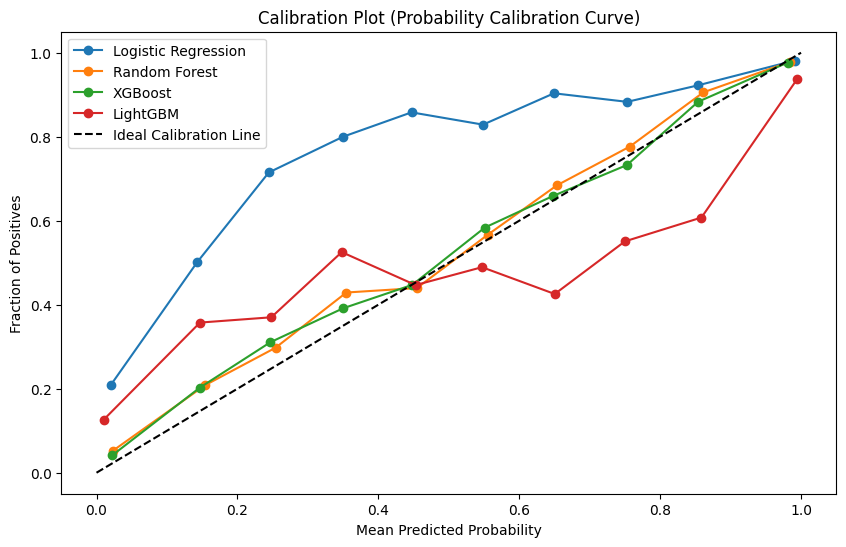


Model Performance Comparison:
                 Model  Accuracy  Precision    Recall  F1 Score  Brier Score
0  Logistic Regression  0.828225   0.964775  0.766569  0.854327     0.134616
1        Random Forest  0.884291   0.924494  0.897182  0.910633     0.083105
2              XGBoost  0.887484   0.921844  0.905539  0.913619     0.081266
3             LightGBM  0.872797   0.901025  0.905928  0.903470     0.103967


In [ ]:
# Calibration Curve & Brier Score 
models = {
    'Logistic Regression': y_pred_proba_log_reg,
    'Random Forest': y_pred_proba_rf,
    'XGBoost': y_pred_proba_xgb,
    'LightGBM': y_pred_proba_lgb
}

plt.figure(figsize=(10, 6))
for model_name, y_pred_proba in models.items():
    prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10, pos_label=1)
    plt.plot(prob_pred, prob_true, marker='o', label=f'{model_name}')
    brier_score = brier_score_loss(y_test, y_pred_proba)
    print(f"\nBrier Score for {model_name}: {brier_score:.4f}")

plt.plot([0, 1], [0, 1], linestyle='--', color='k', label="Ideal Calibration Line")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Plot (Probability Calibration Curve)")
plt.legend()
plt.show()

# result of each models' prediction
model_performance = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1 Score": [],
    "Brier Score": []
}

for model_name, y_pred_proba in models.items():
    y_pred = (y_pred_proba > 0.5).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=1)
    recall = recall_score(y_test, y_pred, zero_division=1)
    f1 = f1_score(y_test, y_pred, zero_division=1)
    brier_score = brier_score_loss(y_test, y_pred_proba)

    model_performance["Model"].append(model_name)
    model_performance["Accuracy"].append(accuracy)
    model_performance["Precision"].append(precision)
    model_performance["Recall"].append(recall)
    model_performance["F1 Score"].append(f1)
    model_performance["Brier Score"].append(brier_score)

performance_df = pd.DataFrame(model_performance)

print("\nModel Performance Comparison:")
print(performance_df)


ROC AUC for Logistic Regression: 0.9329

ROC AUC for Random Forest: 0.9498

ROC AUC for XGBoost: 0.9513

ROC AUC for LightGBM: 0.9429


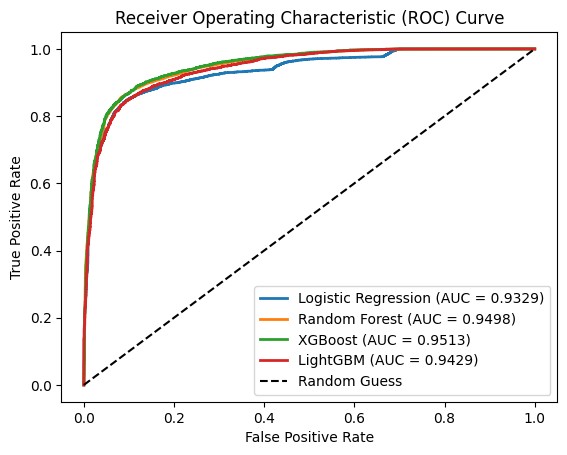

In [ ]:
# Logistic Regression 
y_pred_proba_log_reg = log_reg.predict_proba(X_test_scaled)[:, 1]
roc_auc_log_reg = roc_auc_score(y_test, y_pred_proba_log_reg)
print(f"\nROC AUC for Logistic Regression: {roc_auc_log_reg:.4f}")

fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_pred_proba_log_reg)
plt.plot(fpr_log_reg, tpr_log_reg, lw=2, label=f'Logistic Regression (AUC = {roc_auc_log_reg:.4f})')

# Random Forest 
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print(f"\nROC AUC for Random Forest: {roc_auc_rf:.4f}")

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
plt.plot(fpr_rf, tpr_rf, lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.4f})')

# XGBoost 
y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print(f"\nROC AUC for XGBoost: {roc_auc_xgb:.4f}")

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
plt.plot(fpr_xgb, tpr_xgb, lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.4f})')

# LightGBM 
y_pred_proba_lgb = lgb_model.predict(X_test_scaled)
roc_auc_lgb = roc_auc_score(y_test, y_pred_proba_lgb)
print(f"\nROC AUC for LightGBM: {roc_auc_lgb:.4f}")

fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_pred_proba_lgb)
plt.plot(fpr_lgb, tpr_lgb, lw=2, label=f'LightGBM (AUC = {roc_auc_lgb:.4f})')

# ROC 
plt.plot([0, 1], [0, 1], linestyle='--', color='k', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

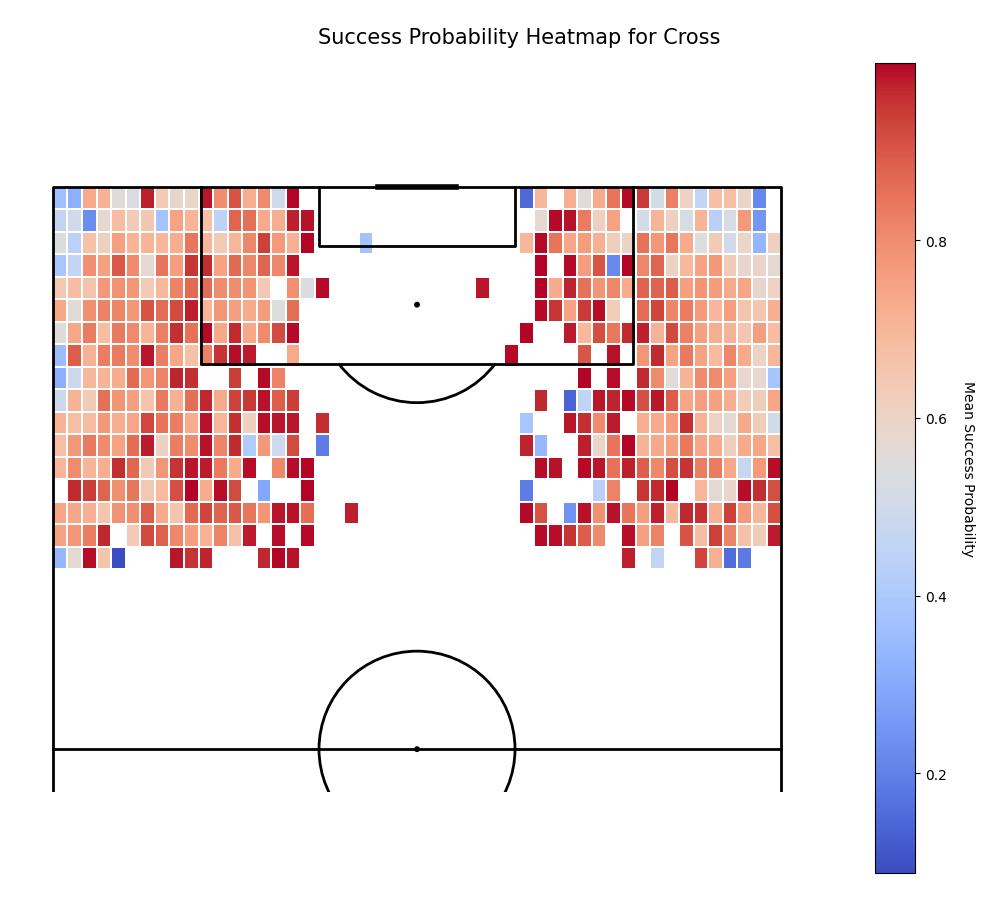

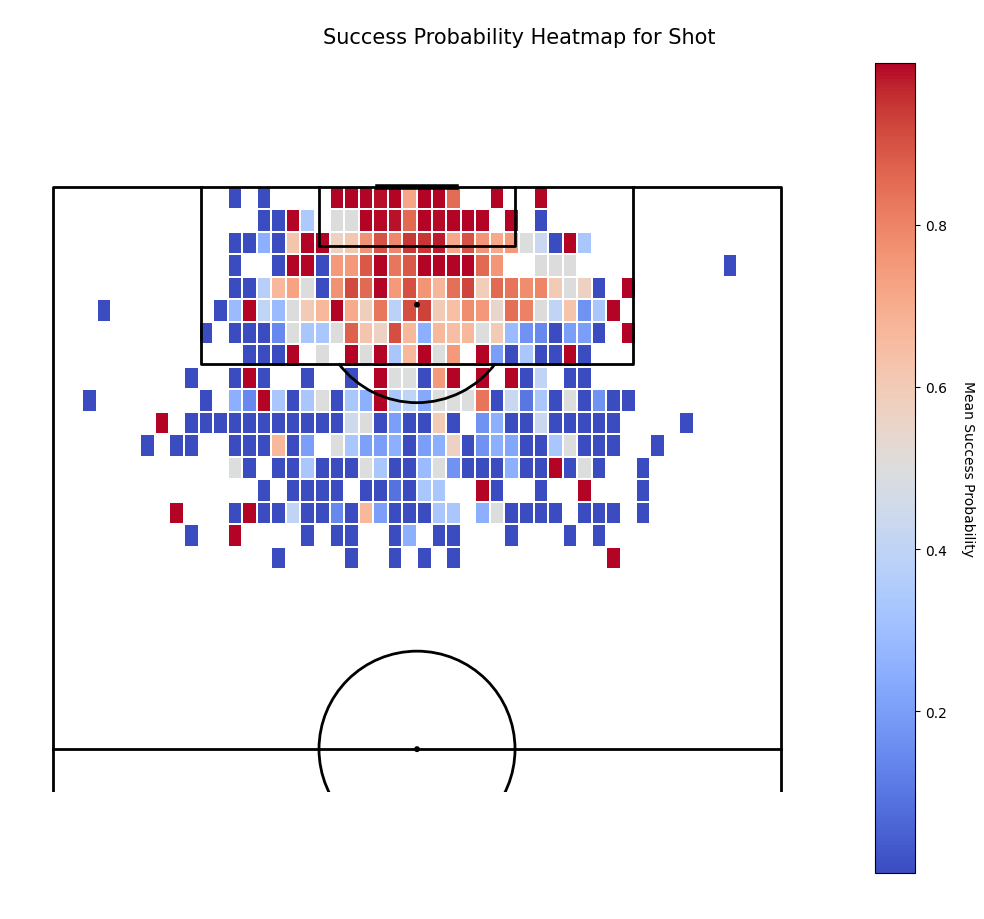

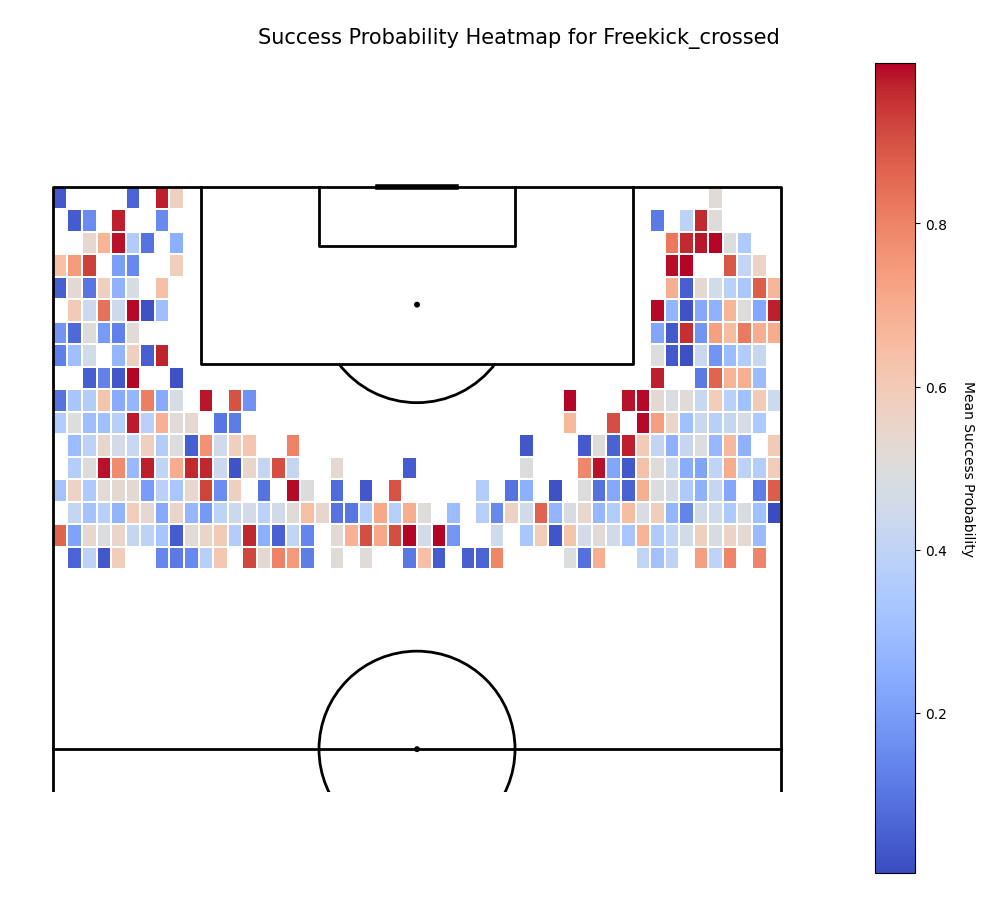

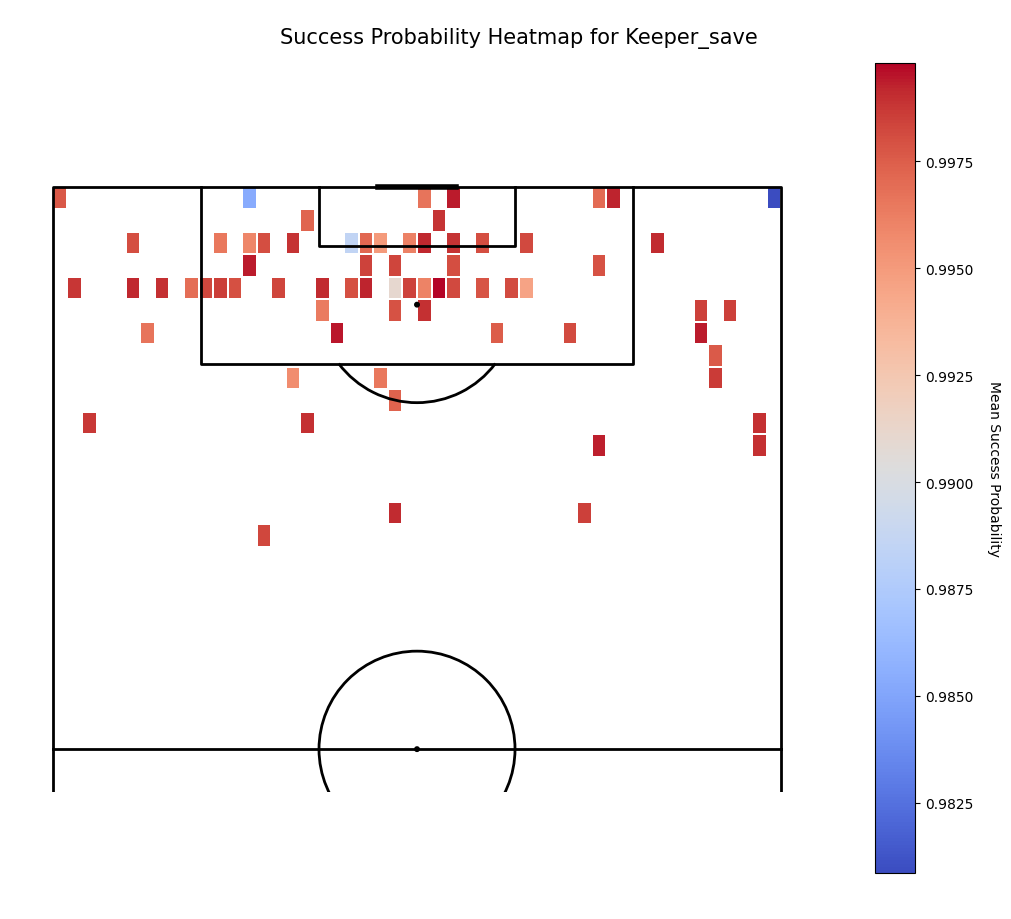

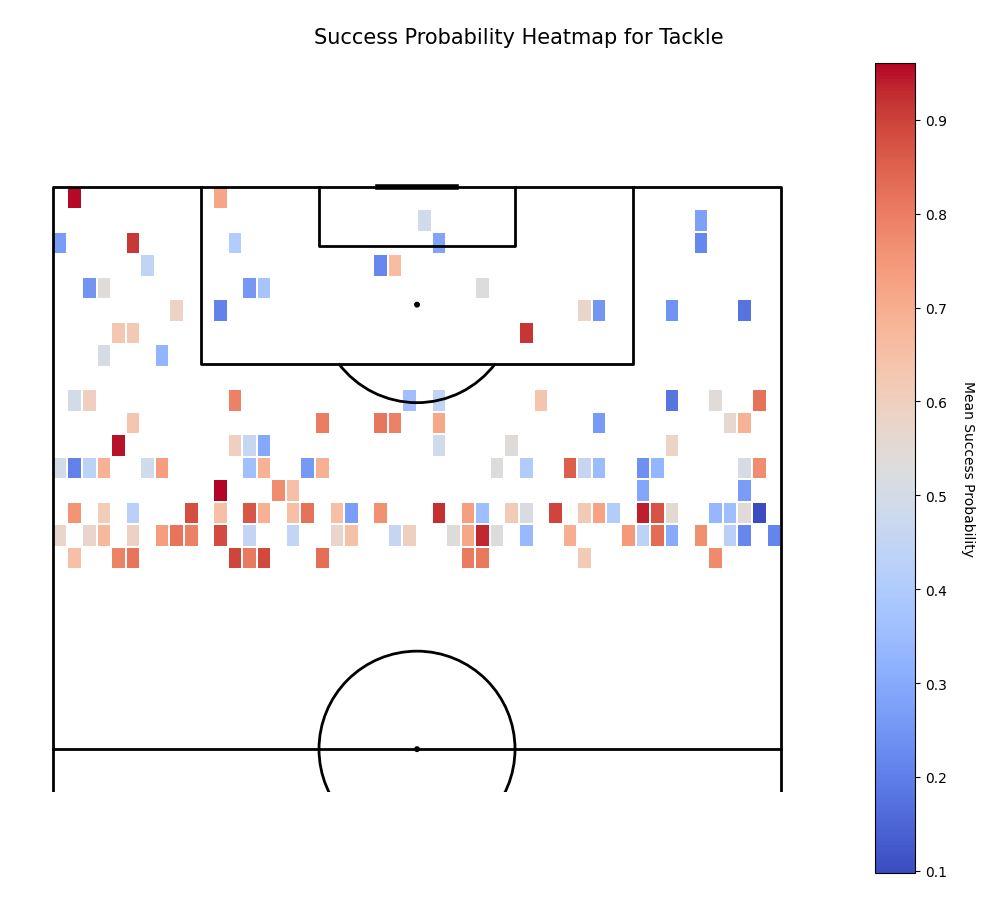

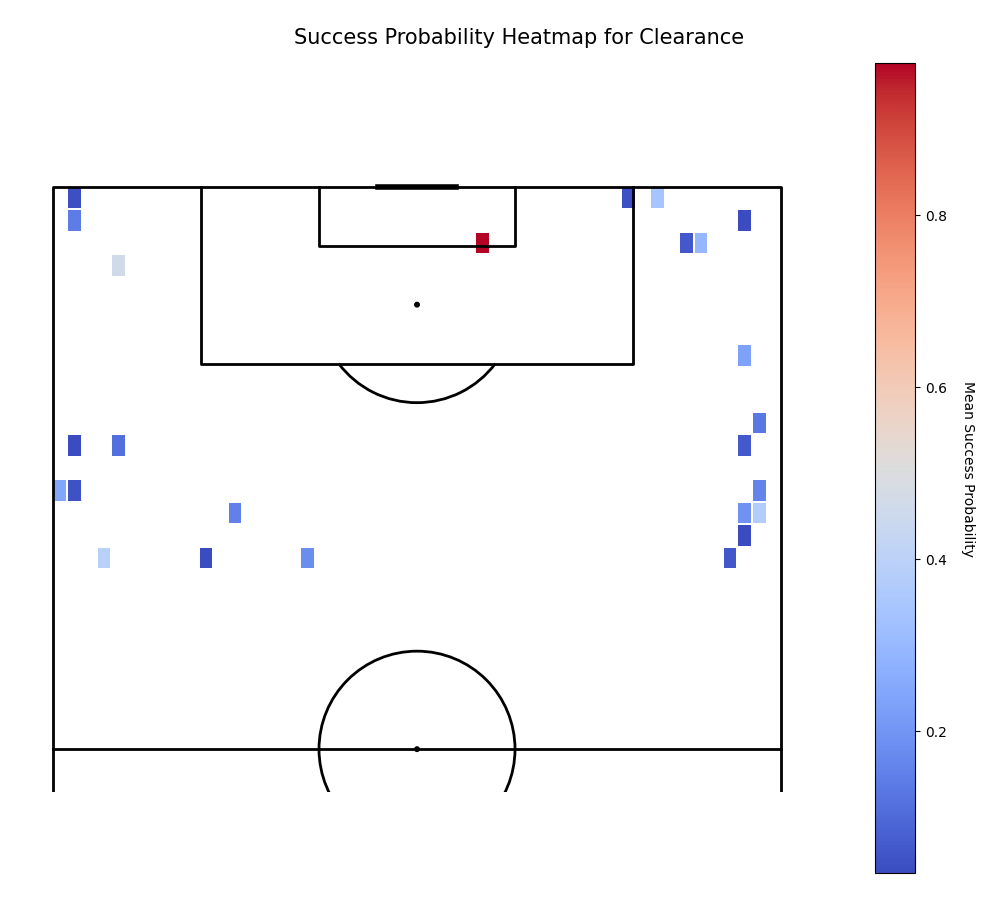

In [ ]:
unique_actions = offensive_data["type_name"].unique()

for action in unique_actions:
    # filtering
    action_data = offensive_data[offensive_data["type_name"] == action]

    # find the equal index of action_data and y_test
    common_indices = action_data.index.intersection(y_test.index)

    # read from y_test
    common_positions = y_test.index.get_indexer(common_indices)

    # read success probability
    action_data = action_data.loc[common_indices]
    action_data["success_probability"] = y_pred_proba_xgb[common_positions]

    # mplsoccer
    pitch = VerticalPitch(
        line_color='black',
        half=True,
        pitch_type='custom',
        pitch_length=105,
        pitch_width=68,
        line_zorder=2
    )
    fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                         endnote_height=0.04, title_space=0, endnote_space=0)

    # Heatmap (success probability)
    bin_statistic = pitch.bin_statistic(
        105 - action_data["start_x"], action_data["start_y"],
        values=action_data["success_probability"],
        statistic="mean", bins=(50, 50)
    )

    # Headmap
    pcm = pitch.heatmap(bin_statistic, ax=ax["pitch"], cmap='coolwarm', edgecolor='white', linewidth=0.01)
    cbar = fig.colorbar(pcm, ax=ax["pitch"], orientation='vertical')
    cbar.set_label('Mean Success Probability', rotation=270, labelpad=20)

    # title of graph
    fig.suptitle(f'Success Probability Heatmap for {action.capitalize()}', fontsize=15)
    plt.show()


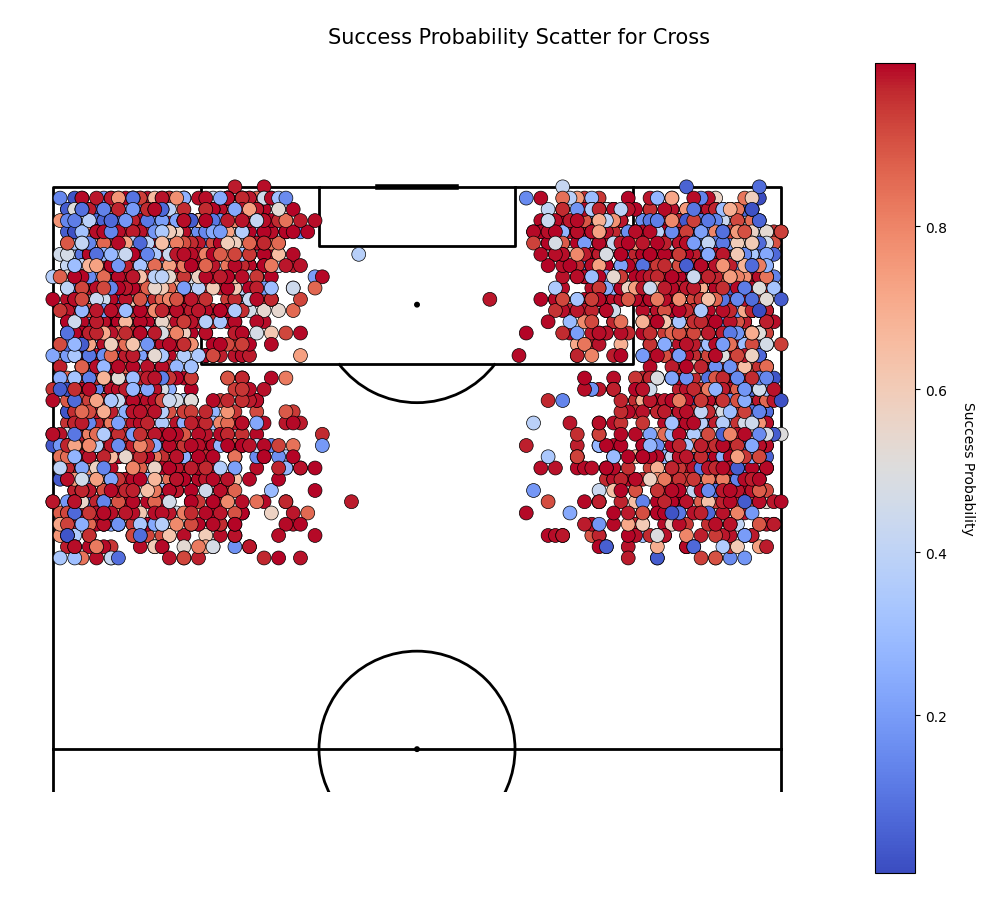

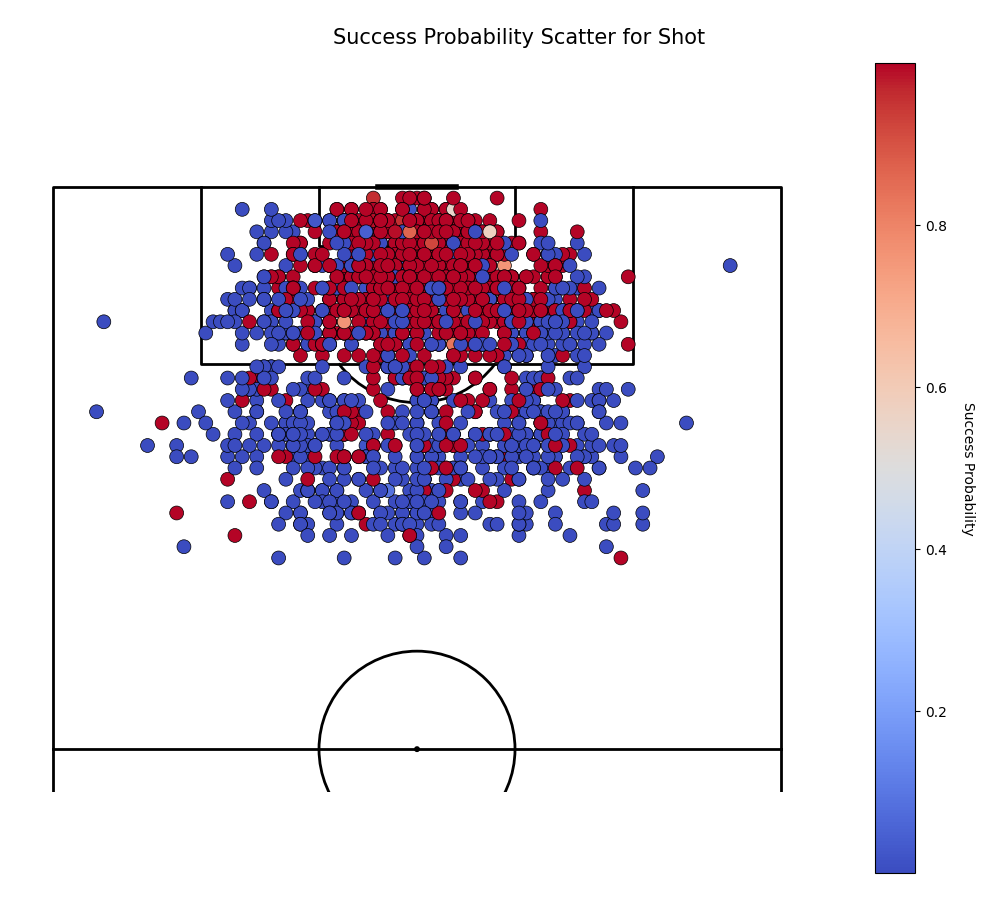

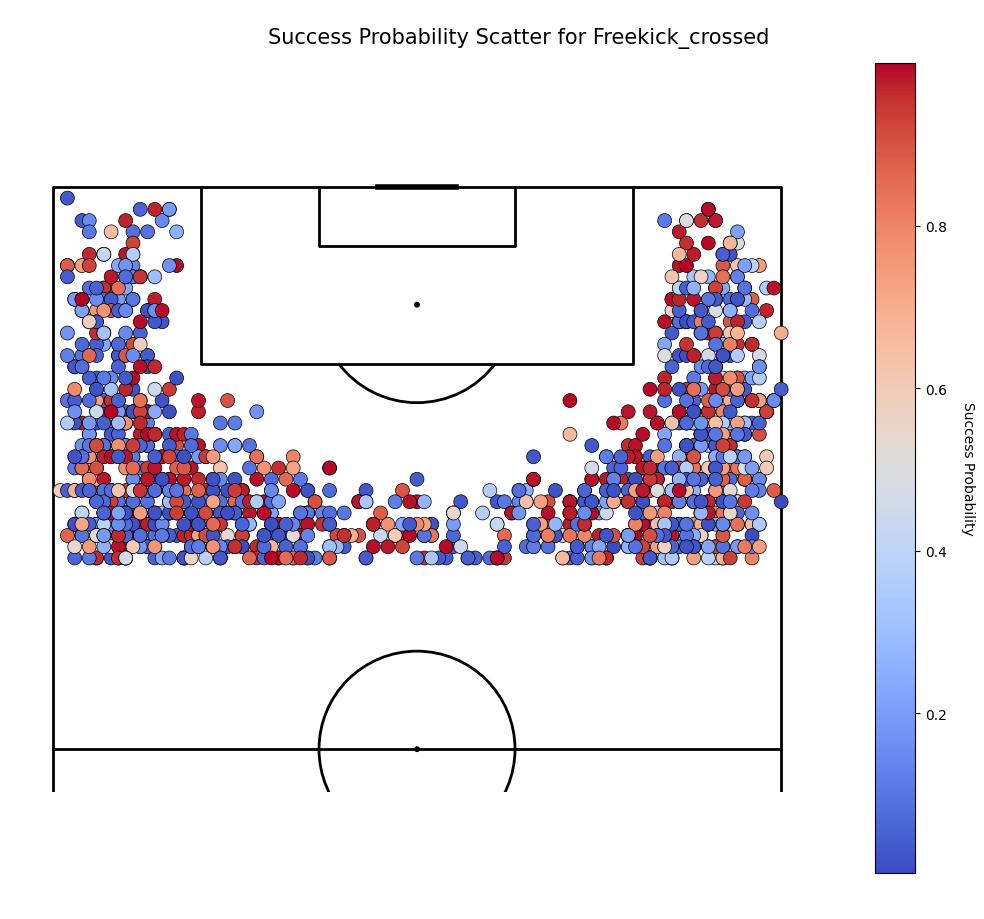

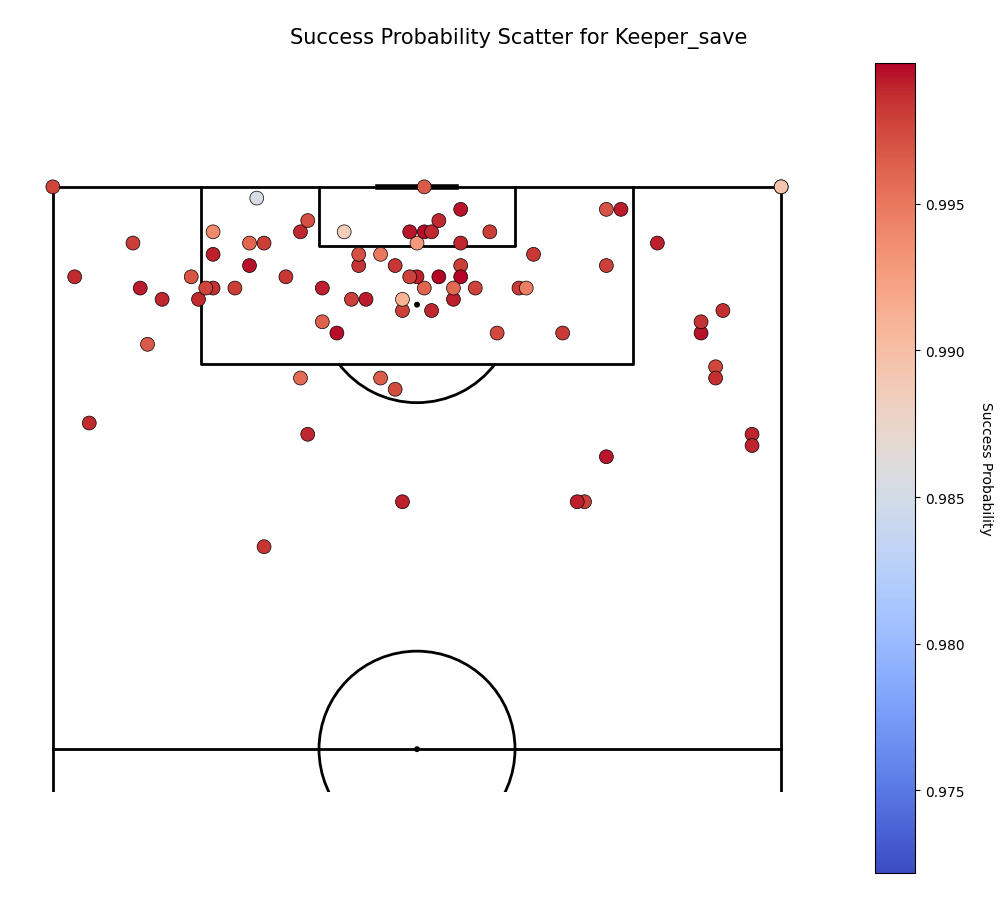

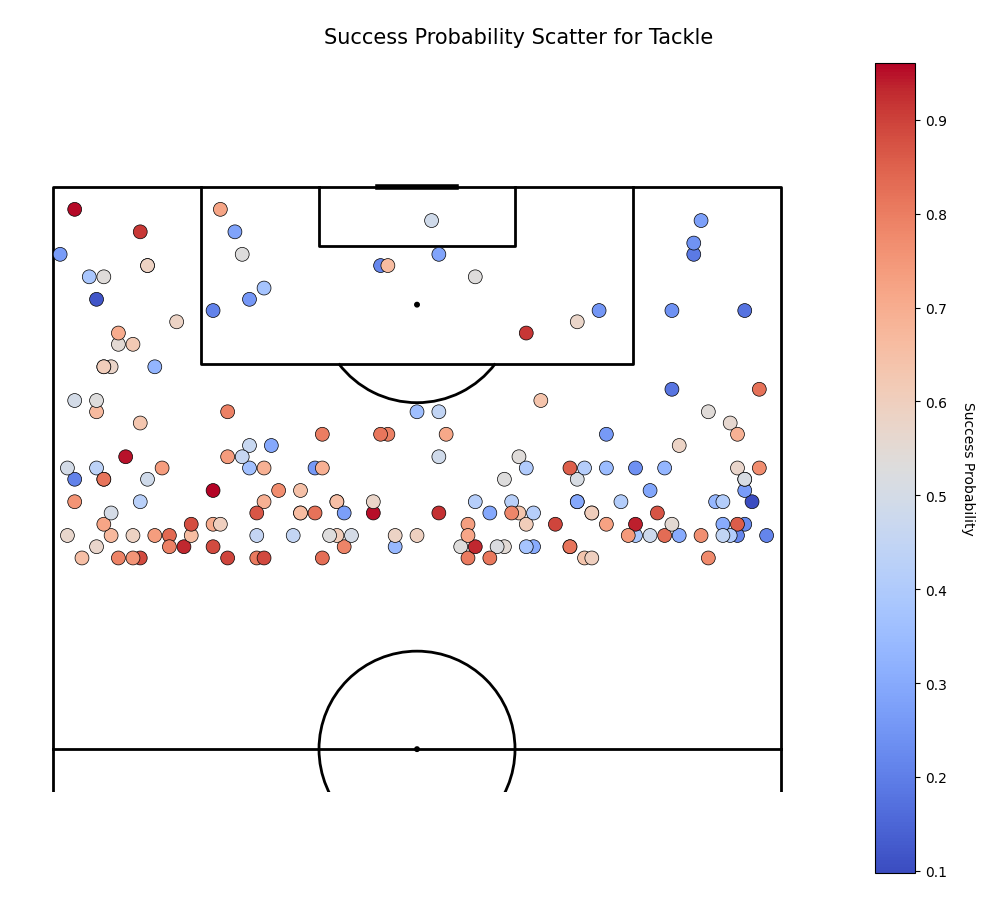

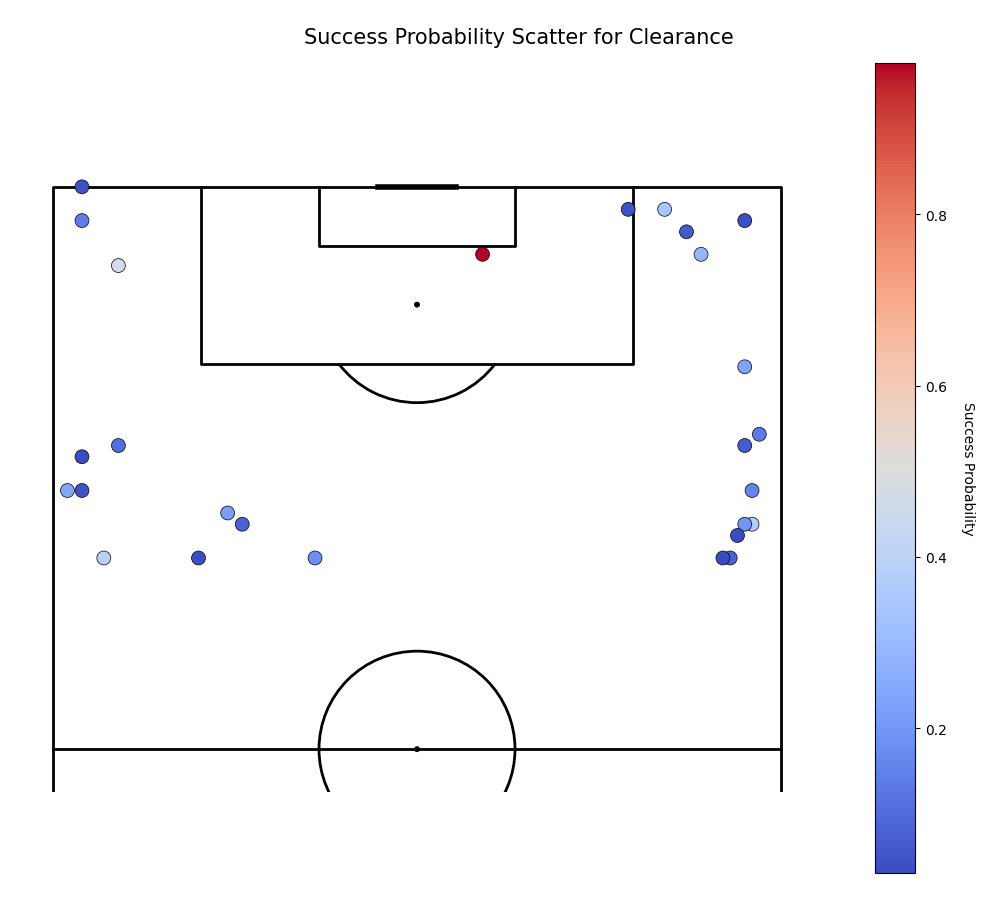

In [ ]:
from mplsoccer import VerticalPitch
import matplotlib.pyplot as plt

unique_actions = offensive_data["type_name"].unique()

for action in unique_actions:
    # filtering
    action_data = offensive_data[offensive_data["type_name"] == action]

    common_indices = action_data.index.intersection(y_test.index)

    common_positions = y_test.index.get_indexer(common_indices)

    action_data = action_data.loc[common_indices]
    action_data["success_probability"] = y_pred_proba_xgb[common_positions]

    # mplsoccer
    pitch = VerticalPitch(
        line_color='black',
        half=True,
        pitch_type='custom',
        pitch_length=105,
        pitch_width=68,
        line_zorder=2
    )
    fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                         endnote_height=0.04, title_space=0, endnote_space=0)

    # scatter 
    sc = pitch.scatter(
        105 - action_data["start_x"], action_data["start_y"],
        c=action_data["success_probability"], cmap="coolwarm", ax=ax["pitch"],
        s=100, edgecolors="black", linewidth=0.5, zorder=3
    )

    cbar = fig.colorbar(sc, ax=ax["pitch"], orientation='vertical')
    cbar.set_label('Success Probability', rotation=270, labelpad=20)

    fig.suptitle(f'Success Probability Scatter for {action.capitalize()}', fontsize=15)
    plt.show()


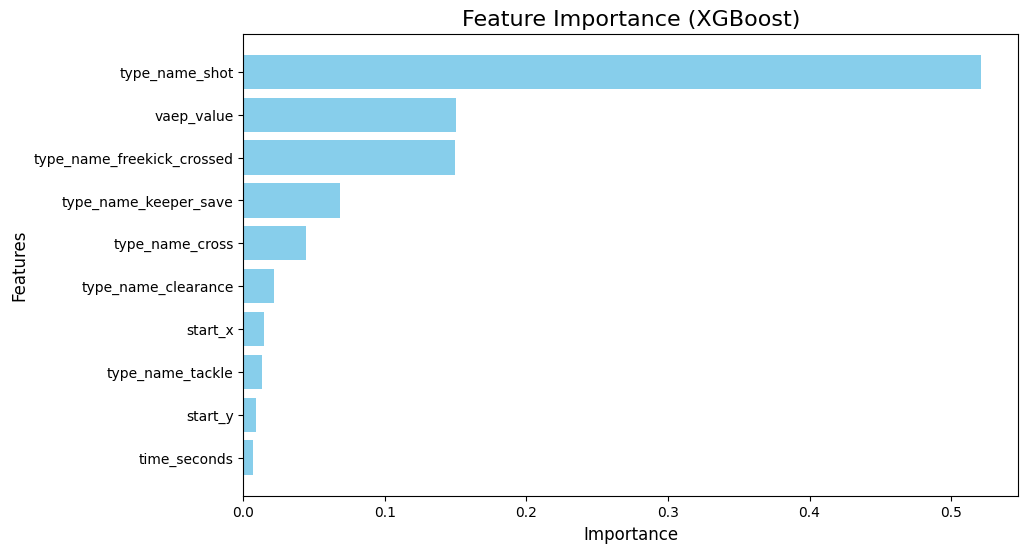

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Feature importance
feature_importances = xgb_model.feature_importances_

# 
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# ploting
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis() 
plt.title('Feature Importance (XGBoost)', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()
